프로젝트 샘플
http://naver.me/50oquHxy

# 여성 의류 사이즈 기준 및 상품 추천 시스템 모델 개발

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import selenium
import requests

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

from urllib import request
from urllib.request import urlopen, urlretrieve
from urllib.parse import quote_plus

## 1) 원피스 전체 (미니, 미디, 멕시 원피스) 크롤링

### ① 1~10페이지 내의 상품 접속 '링크만' 추출

In [3]:
#1~10페이지 내의 상품 접속 '링크만' 추출
#soup.select(selector= '#searchList > li:nth-child(1) > div.li_inner > div.article_info > p.list_info > a')

dresses = []

for i in range(1, 11):
    url = f'https://www.musinsa.com/categories/item/020?d_cat_cd=020&brand=&list_kind=small&sort=sale_high&sub_sort=3m&page={i}&display_cnt=90&group_sale=&exclusive_yn=&sale_goods=&timesale_yn=&ex_soldout=&kids=&color=&price1=&price2=&shoeSizeOption=&tags=&campaign_id=&includeKeywords=&measure='
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'html.parser')
    #사이트 내 상품명 & 링크
    products = soup.select(selector = 'p.list_info > a')
    
    #링크만 추출
    for product in products:
        dresses.append(product['href'])

dress_links = []

#링크 모음 리스트 dresses 내에 있는 링크에 대한 조건문
for dress in dresses:
    if 'http:' in dress:
        pass
    elif 'https:' in dress:
        pass
    else:
        dress = 'http:' + dress
        dress_links.append(dress)
        
print(dress_links)

['http://www.musinsa.com/app/goods/2827957?loc=goods_rank', 'http://www.musinsa.com/app/goods/2714524?loc=goods_rank', 'http://www.musinsa.com/app/goods/2788583?loc=goods_rank', 'http://www.musinsa.com/app/goods/2374001?loc=goods_rank', 'http://www.musinsa.com/app/goods/1723873?loc=goods_rank', 'http://www.musinsa.com/app/goods/1683243?loc=goods_rank', 'http://www.musinsa.com/app/goods/2742440?loc=goods_rank', 'http://www.musinsa.com/app/goods/1792540?loc=goods_rank', 'http://www.musinsa.com/app/goods/1630818?loc=goods_rank', 'http://www.musinsa.com/app/goods/2429700?loc=goods_rank', 'http://www.musinsa.com/app/goods/2368991?loc=goods_rank', 'http://www.musinsa.com/app/goods/2377826?loc=goods_rank', 'http://www.musinsa.com/app/goods/2398607?loc=goods_rank', 'http://www.musinsa.com/app/goods/987370?loc=goods_rank', 'http://www.musinsa.com/app/goods/1963314?loc=goods_rank', 'http://www.musinsa.com/app/goods/2647666?loc=goods_rank', 'http://www.musinsa.com/app/goods/2587988?loc=goods_rank

In [4]:
dress_links[0]

'http://www.musinsa.com/app/goods/2827957?loc=goods_rank'

### ② 1~10페이지 내 상품들 각각의 S,M,L,XL 사이즈 출력 (수정)

In [5]:
#1~10페이지 내 상품들 각각의 S,M,L,XL 사이즈 출력 (오류 수정)
header = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36'}
dress_data = pd.DataFrame()

for dress_link in dress_links:
    html = requests.get(dress_link, headers = header).text
    soup = BeautifulSoup(html, 'html.parser')
    columns = soup.find_all(class_ = 'item_val')    #사이즈표의 칼럼
    size_cats = soup.select('#size_table > tbody > tr > th')    #사이즈표의 사이즈
    #size_table > tbody
    #size_table > tbody > tr:nth-child(3) > td:nth-child(2)
    
    if columns:
        #사이즈표의 칼럼명 (총장, 어깨너비, ..)
        columns_parts = [column.text.strip() for column in columns]
        #사이즈표의 사이즈명 (S, M, ..)
        size_cate = [cate.text.strip() for cate in size_cats][1:]
        
        #전체 사이즈의 전체 치수 모음 리스트
        size_val = []
        
        for i in range(3, len(size_cats) + 3):
            for j in range(2, len(columns_parts) + 2):
                types = soup.select(f'#size_table > tbody > tr:nth-child({i}) > td:nth-child({j})')
                types = re.sub('[^0-9.]', '', str(types))
                size_val.append(types.strip())
                
        size_val = [v for v in size_val if v]
        
        #각각의 상품 사이즈표 칼럼수 만큼 치수 분배
        n = len(columns_parts)    #사이즈표 칼럼수
        results = [size_val[i * n: (i+1)*n] for i in range((len(size_val) + n-1) // n)]
        colpts = columns_parts * (len(results))
        
        columns_parts = columns_parts * (int(len(size_val) / len(columns_parts)))
        
        categories = []
        
        n = int(len(size_val) / len(size_cate))
        
        for size in size_cate:
            for i in range(n):
                categories.append(size)
                
        size_val_df = pd.DataFrame(size_val)
        size_cate_df = pd.DataFrame(categories)
        columns_part_df = pd.DataFrame(columns_parts)
        
        df_1 = pd.concat([size_val_df, size_cate_df], axis=1)
        df_2 = pd.concat([df_1, columns_part_df], axis=1)
        
        dress_data = pd.concat([dress_data, df_2], axis=0)
        
    else:
        continue
        
dress_data

,0,0,0
0,128,34,총장
1,60,34,어깨너비
2,63,34,가슴단면
3,55,34,소매길이
4,129,36,총장
...,...,...,...
11,59,M,소매길이
12,123,L,총장
13,36,L,어깨너비
14,51,L,가슴단면


In [6]:
dress_data.columns = ['measures', 'size', 'columns']
dress_data['size'].value_counts()

S          1487
M          1452
FREE       1053
L           252
옵션없음        205
           ... 
단품원피스S        2
WHITE/M       2
WHITE/S       2
medium        2
NAVY          2
Name: size, Length: 157, dtype: int64

In [8]:
dress_data

,measures,size,columns
0,128,34,총장
1,60,34,어깨너비
2,63,34,가슴단면
3,55,34,소매길이
4,129,36,총장
...,...,...,...
11,59,M,소매길이
12,123,L,총장
13,36,L,어깨너비
14,51,L,가슴단면


In [9]:
dress_data.to_csv('C:/Users/admin/#실습(221031~221111)/dress_data.csv')

## 2) 무신사 내 상품 사이즈의 S, M, L, XL 치수의 평균값 (파이차트 시각화)

In [4]:
dress_data = pd.read_csv('C:/Users/AB350/#실습(221031~221111)/dress_data.csv')
dress_data

,Unnamed: 0,measures,size,columns
0,0,128.0,34,총장
1,1,60.0,34,어깨너비
2,2,63.0,34,가슴단면
3,3,55.0,34,소매길이
4,4,129.0,36,총장
...,...,...,...,...
6646,11,59.0,M,소매길이
6647,12,123.0,L,총장
6648,13,36.0,L,어깨너비
6649,14,51.0,L,가슴단면


In [5]:
dress_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6651 entries, 0 to 6650
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6651 non-null   int64  
 1   measures    6651 non-null   float64
 2   size        6650 non-null   object 
 3   columns     6648 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 208.0+ KB


### * 결측치 제거

In [6]:
dress_data.isnull().sum()

Unnamed: 0    0
measures      0
size          1
columns       3
dtype: int64

In [7]:
dress_data.dropna(axis=0, inplace=True)

In [8]:
dress_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6648 entries, 0 to 6650
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6648 non-null   int64  
 1   measures    6648 non-null   float64
 2   size        6648 non-null   object 
 3   columns     6648 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 259.7+ KB


In [9]:
dress_data.reset_index(inplace=True)
dress_data

,index,Unnamed: 0,measures,size,columns
0,0,0,128.0,34,총장
1,1,1,60.0,34,어깨너비
2,2,2,63.0,34,가슴단면
3,3,3,55.0,34,소매길이
4,4,4,129.0,36,총장
...,...,...,...,...,...
6643,6646,11,59.0,M,소매길이
6644,6647,12,123.0,L,총장
6645,6648,13,36.0,L,어깨너비
6646,6649,14,51.0,L,가슴단면


In [10]:
dress_data = dress_data.iloc[:, 2:]
dress_data

,measures,size,columns
0,128.0,34,총장
1,60.0,34,어깨너비
2,63.0,34,가슴단면
3,55.0,34,소매길이
4,129.0,36,총장
...,...,...,...
6643,59.0,M,소매길이
6644,123.0,L,총장
6645,36.0,L,어깨너비
6646,51.0,L,가슴단면


### ① 의미없는 사이즈 표기 제외

In [11]:
dress_data['size'].unique()

array(['34', '36', '38', 'FREE', 'S', 'M', 'free', 'S SIZE', 'M SIZE',
       '옵션없음', '1(S)', '2(M)', 'XS', 'L', '(S~M)', '(L~XL)', 'OS', '1',
       '2', 'BLACK_FREE', 'BLACK', '085', '088', '091', '1 SIZE',
       '2 SIZE', 'S_085', 'M_090', 'S[085]', 'M[090]', 'F',
       'ONEPIECE BLACK:1', 'ONEPIECE BLACK:2', 'Free', 'medium', 'XL',
       '100', '110', '120', '130', '140', '150', '프리사이즈', '92cm (1.5-2y)',
       '98cm (2-3y)', '104cm (3-4y)', '110cm (4-5y)', '116cm (5-6y)',
       '122cm (6-7y)', '00S', '00M', '네이비', 's size', 'm size', 'S-Long',
       'ONE SIZE', '85', '88', '91', '9M', '12M', '18M', '24M', 'S(55)',
       'M(66)', '55', '66', '77', 'S_PURPLE', 'ONE', '0', '090', '095',
       'XS55', 'S66', 'M77', '38(55)', '40(66)', 'XS_85', 'S_90', 'M_088',
       'L_091', 'WHITE/S', 'WHITE/M', 'Free / Beige', 'Free / Black',
       '네이비 M', '네이비 L', '화이트 M', '화이트 L', '01S', '02M', 'L[095]', '프리',
       '단품원피스S', '단품원피스M', '단품원피스L', 'm', 's', '옐로우 M', '옐로우 L',
       'charc

In [12]:
drop_size_columns = ['34', '36', '38', '(S~M)', '(L~XL)', '1', '2', 'BLACK', '085', '088', '091',
                     '1 SIZE', '2 SIZE', 'ONEPIECE BLACK:1', 'ONEPIECE BLACK:2',
                     '100', '110', '120', '130', '140', '150', '92cm (1.5-2y)', '98cm (2-3y)',
                     '104cm (3-4y)', '110cm (4-5y)', '116cm (5-6y)', '122cm (6-7y)', '네이비',
                     '85', '88', '91', '9M', '12M', '18M', '24M', '55', '66', '77', '0', '090', '095',
                     '38(55)', '40(66)', 'charcoal', '1-2세(86-92cm)', '2-3세(92-98cm)', '3-4세(98-104cm)',
                     '4-5세(104-110cm)', '5-6세(110-116cm)', '7-8세(122-128cm)', '40', '90', 'XXS', '55(85)', '66(90)', '77(95)',
                     '88(100)', 'SM', 'Short', 'Long', '3T', '5T', '7T', '9T', '080', '8', '10', '12', '14', '16',
                     'blue', '145', '04', '06', '07', '08', '11T', '4', '6', '95', '3(L)', 'NAVY']

drop_index = []

for i in range(len(dress_data['size'])):
    if dress_data['size'][i] in drop_size_columns:
        drop_index.append(i)
        #print(dress_data.drop(dress_data.iloc[i, :], axis=0))
    else:
        continue

dress_data.drop(drop_index, inplace=True)

#print('drop_index:', drop_index)
#print()
print('unique:', dress_data['size'].unique())

unique: ['FREE' 'S' 'M' 'free' 'S SIZE' 'M SIZE' '옵션없음' '1(S)' '2(M)' 'XS' 'L'
 'OS' 'BLACK_FREE' 'S_085' 'M_090' 'S[085]' 'M[090]' 'F' 'Free' 'medium'
 'XL' '프리사이즈' '00S' '00M' 's size' 'm size' 'S-Long' 'ONE SIZE' 'S(55)'
 'M(66)' 'S_PURPLE' 'ONE' 'XS55' 'S66' 'M77' 'XS_85' 'S_90' 'M_088'
 'L_091' 'WHITE/S' 'WHITE/M' 'Free / Beige' 'Free / Black' '네이비 M' '네이비 L'
 '화이트 M' '화이트 L' '01S' '02M' 'L[095]' '프리' '단품원피스S' '단품원피스M' '단품원피스L' 'm'
 's' '옐로우 M' '옐로우 L' '1ONE SIZE' 'SMALL' 'MEDIUM' 'XS(55)' 'S(66)' 'M(77)'
 'S(36)' 'M(38)' 'FF(FREE)' 'S(85)' 'M(90)' 'FRE' 'BLACK-FREE' 'black / F'
 'One size' 'S(085)' 'M(088)']


In [ ]:
#mini_dress_data.isin(drop_size_columns).sum()
#mini_dress_data[mini_dress_data['size'] in drop_size_columns]

In [13]:
dress_data = dress_data.reset_index().iloc[:, 1:]
dress_data

,measures,size,columns
0,82.0,FREE,총장
1,42.0,FREE,어깨너비
2,50.0,FREE,가슴단면
3,62.0,FREE,소매길이
4,121.0,S,총장
...,...,...,...
5506,59.0,M,소매길이
5507,123.0,L,총장
5508,36.0,L,어깨너비
5509,51.0,L,가슴단면


### ② 사이즈 표기 통일 (FREE, XS, S, M, L, XL)

In [14]:
dress_data['size'].unique()

array(['FREE', 'S', 'M', 'free', 'S SIZE', 'M SIZE', '옵션없음', '1(S)',
       '2(M)', 'XS', 'L', 'OS', 'BLACK_FREE', 'S_085', 'M_090', 'S[085]',
       'M[090]', 'F', 'Free', 'medium', 'XL', '프리사이즈', '00S', '00M',
       's size', 'm size', 'S-Long', 'ONE SIZE', 'S(55)', 'M(66)',
       'S_PURPLE', 'ONE', 'XS55', 'S66', 'M77', 'XS_85', 'S_90', 'M_088',
       'L_091', 'WHITE/S', 'WHITE/M', 'Free / Beige', 'Free / Black',
       '네이비 M', '네이비 L', '화이트 M', '화이트 L', '01S', '02M', 'L[095]', '프리',
       '단품원피스S', '단품원피스M', '단품원피스L', 'm', 's', '옐로우 M', '옐로우 L',
       '1ONE SIZE', 'SMALL', 'MEDIUM', 'XS(55)', 'S(66)', 'M(77)',
       'S(36)', 'M(38)', 'FF(FREE)', 'S(85)', 'M(90)', 'FRE',
       'BLACK-FREE', 'black / F', 'One size', 'S(085)', 'M(088)'],
      dtype=object)

In [15]:
print(dress_data['size'].iloc[0])
print(dress_data['size'].iloc[0].replace(dress_data['size'].iloc[0], 'Free'))

FREE
Free


#### * size 표기를 모두 대문자로 변경

In [16]:
for i in range(len(dress_data['size'])):
    dress_data['size'].iloc[i] = dress_data['size'].iloc[i].upper()

print(dress_data['size'].unique())

C:\Users\AB350\AppData\Local\Temp\ipykernel_3908\1830756825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dress_data['size'].iloc[i] = dress_data['size'].iloc[i].upper()


['FREE' 'S' 'M' 'S SIZE' 'M SIZE' '옵션없음' '1(S)' '2(M)' 'XS' 'L' 'OS'
 'BLACK_FREE' 'S_085' 'M_090' 'S[085]' 'M[090]' 'F' 'MEDIUM' 'XL' '프리사이즈'
 '00S' '00M' 'S-LONG' 'ONE SIZE' 'S(55)' 'M(66)' 'S_PURPLE' 'ONE' 'XS55'
 'S66' 'M77' 'XS_85' 'S_90' 'M_088' 'L_091' 'WHITE/S' 'WHITE/M'
 'FREE / BEIGE' 'FREE / BLACK' '네이비 M' '네이비 L' '화이트 M' '화이트 L' '01S' '02M'
 'L[095]' '프리' '단품원피스S' '단품원피스M' '단품원피스L' '옐로우 M' '옐로우 L' '1ONE SIZE'
 'SMALL' 'XS(55)' 'S(66)' 'M(77)' 'S(36)' 'M(38)' 'FF(FREE)' 'S(85)'
 'M(90)' 'FRE' 'BLACK-FREE' 'BLACK / F' 'S(085)' 'M(088)']


#### * 사이즈 표기 통일 (Free, XS, S, M, L, XL)

In [17]:
#re.sub(".+123.+", "#", string)
#re.search("L.*", mini_dress_data['size'].iloc[i])
for i in range(len(dress_data['size'])):
    if re.search("F.*", dress_data['size'].iloc[i]):
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'Free')
        
    elif 'ONE' in dress_data['size'].iloc[i]:
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'Free')
        
    elif 'OS' in dress_data['size'].iloc[i]:
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'Free')
        
    elif '프리' in dress_data['size'].iloc[i]:
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'Free')
        
    elif '옵션없음' in dress_data['size'].iloc[i]:
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'Free')
        
    elif 'XS' in dress_data['size'].iloc[i]:
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'XS')
        
    elif re.search("M.*", dress_data['size'].iloc[i]):
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'M')
    
    elif re.search("S.*", dress_data['size'].iloc[i]):
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'S')
        
    elif 'XL' in dress_data['size'].iloc[i]:
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'XL')
        
    else:
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'L')

C:\Users\AB350\AppData\Local\Temp\ipykernel_3908\3593534874.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'Free')
C:\Users\AB350\AppData\Local\Temp\ipykernel_3908\3593534874.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'S')
C:\Users\AB350\AppData\Local\Temp\ipykernel_3908\3593534874.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:/

In [18]:
dress_data['size'].unique()

array(['Free', 'S', 'M', 'XS', 'L', 'XL'], dtype=object)

### ③ 사이즈별 치수의 평균값 (총장, 어깨너비, 가슴단면, 소매길이)

In [19]:
dress_data.groupby(['columns', 'size'])[['measures']].mean().round(3)

measures
columns size          
가슴단면    Free    47.301
        L       48.047
        M       46.411
        S       44.193
        XL      51.500
        XS      42.482
밑단단면    Free    28.000
        L       60.500
        M       53.094
        S       50.143
        XL      63.000
밑위      Free    34.000
소매길이    Free    53.025
        L       29.199
        M       39.998
        S       40.119
        XL      19.429
        XS      38.153
어깨너비    Free    41.383
        L       39.155
        M       40.361
        S       39.000
        XL      44.714
        XS      38.905
엉덩이단면   Free    53.664
        L       48.900
        M       50.275
        S       48.239
        XL      52.000
        XS      34.250
총장      Free    94.648
        L       97.710
        M       90.751
        S       88.894
        XL      94.500
        XS      87.778
허리단면    Free    32.000
        L       41.000
        M       41.344
        S       39.357
        XL      43.500
허벅지단면   Free    27.000

In [20]:
dress_XS = dress_data.query("size == 'XS'")
dress_S = dress_data.query("size == 'S'")
dress_M = dress_data.query("size == 'M'")
dress_Free = dress_data.query("size == 'Free'")
dress_L = dress_data.query("size == 'L'")
dress_XL = dress_data.query("size == 'XL'")

#총장
print('XS_총장:', np.round(dress_XS.query("columns == '총장'")['measures'].mean(), 3))
print('S_총장:', np.round(dress_S.query("columns == '총장'")['measures'].mean(), 3))
print('M_총장:', np.round(dress_M.query("columns == '총장'")['measures'].mean(), 3))
print('Free_총장:', np.round(dress_Free.query("columns == '총장'")['measures'].mean(), 3))
print('L_총장:', np.round(dress_L.query("columns == '총장'")['measures'].mean(), 3))
print('XL_총장:', np.round(dress_XL.query("columns == '총장'")['measures'].mean(), 3))
print()

#어깨너비
print('XS_어깨너비:', np.round(dress_XS.query("columns == '어깨너비'")['measures'].mean(), 3))
print('S_어깨너비:', np.round(dress_S.query("columns == '어깨너비'")['measures'].mean(), 3))
print('M_어깨너비:', np.round(dress_M.query("columns == '어깨너비'")['measures'].mean(), 3))
print('Free_어깨너비:', np.round(dress_Free.query("columns == '어깨너비'")['measures'].mean(), 3))
print('L_어깨너비:', np.round(dress_L.query("columns == '어깨너비'")['measures'].mean(), 3))
print('XL_어깨너비:', np.round(dress_XL.query("columns == '어깨너비'")['measures'].mean(), 3))
print()

#가슴단면
print('XS_가슴단면:', np.round(dress_XS.query("columns == '가슴단면'")['measures'].mean(), 3))
print('S_가슴단면:', np.round(dress_S.query("columns == '가슴단면'")['measures'].mean(), 3))
print('M_가슴단면:', np.round(dress_M.query("columns == '가슴단면'")['measures'].mean(), 3))
print('Free_가슴단면:', np.round(dress_Free.query("columns == '가슴단면'")['measures'].mean(), 3))
print('L_가슴단면:', np.round(dress_L.query("columns == '가슴단면'")['measures'].mean(), 3))
print('XL_가슴단면:', np.round(dress_XL.query("columns == '가슴단면'")['measures'].mean(), 3))
print()

#소매길이
print('XS_소매길이:', np.round(dress_XS.query("columns == '소매길이'")['measures'].mean(), 3))
print('S_소매길이:', np.round(dress_S.query("columns == '소매길이'")['measures'].mean(), 3))
print('M_소매길이:', np.round(dress_M.query("columns == '소매길이'")['measures'].mean(), 3))
print('Free_소매길이:', np.round(dress_Free.query("columns == '소매길이'")['measures'].mean(), 3))
print('L_소매길이:', np.round(dress_L.query("columns == '소매길이'")['measures'].mean(), 3))
print('XL_소매길이:', np.round(dress_XL.query("columns == '소매길이'")['measures'].mean(), 3))

XS_총장: 87.778
S_총장: 88.894
M_총장: 90.751
Free_총장: 94.648
L_총장: 97.71
XL_총장: 94.5

XS_어깨너비: 38.905
S_어깨너비: 39.0
M_어깨너비: 40.361
Free_어깨너비: 41.383
L_어깨너비: 39.155
XL_어깨너비: 44.714

XS_가슴단면: 42.482
S_가슴단면: 44.193
M_가슴단면: 46.411
Free_가슴단면: 47.301
L_가슴단면: 48.047
XL_가슴단면: 51.5

XS_소매길이: 38.153
S_소매길이: 40.119
M_소매길이: 39.998
Free_소매길이: 53.025
L_소매길이: 29.199
XL_소매길이: 19.429


### ④ 사이즈 코리아 데이터

In [21]:
dt_2020 = pd.read_csv("C:/Users/AB350/#실습(221031~221111)/2020_size_measures.csv").query("성별 == '여'")
dt_2020[:5]

C:\Users\AB350\AppData\Local\Temp\ipykernel_3908\2322243998.py:1: DtypeWarning: Columns (8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  dt_2020 = pd.read_csv("C:/Users/AB350/#실습(221031~221111)/2020_size_measures.csv").query("성별 == '여'")


,Unnamed: 0,HUMAN_ID,성별,조사년도,조사일,나이,측정지,측정복\n젖가슴둘레,측정복\n상의,측정복\n배꼽수준허리둘레,...,128. 배꼽수준앞중심길이,129. 배꼽수준등길이,130. 목뒤젖꼭지길이,131. 목뒤젖꼭지허리둘레선길이,132. 배꼽수준샅앞뒤길이,133. 앉은눈높이,134. 앉은목뒤높이,135. 앉은어깨높이,136. 앉은팔꿈치높이(팔굽힌),137. 위팔수직길이(팔굽힌)
3,4,20_F_1465,여,2020,1116,42,서울/경기/강원,86.0,85XL,88.0,...,449,453.0,356.5,546.5,882,796,659,626.0,294.0,332.0
4,5,20_F_1467,여,2020,1116,42,서울/경기/강원,73.6,75M,74.5,...,360,391.0,331.5,477.5,731,738,592,544.0,234.0,310.0
5,6,20_F_1477,여,2020,1116,40,서울/경기/강원,74.3,75M,77.0,...,372,405.0,326.5,488.5,749,738,601,552.0,203.0,349.0
6,7,20_F_1486,여,2020,1117,43,서울/경기/강원,77.5,80L,78.0,...,434,428.0,331.5,517.5,741,753,611,581.0,268.0,313.0
7,8,20_F_1490,여,2020,1117,40,서울/경기/강원,80.0,80L,80.0,...,405,415.0,333.5,527.5,696,716,578,544.0,245.0,299.0


In [22]:
dt_2020.loc[:, ['002. 키 ', '018. 가슴너비 ', '041. 가슴둘레 ']]

,002. 키,018. 가슴너비,041. 가슴둘레
3,1685,309,993
4,1602,263,818
5,1642,263,839
6,1589,276,867
7,1531,280,902
...,...,...,...
5069,1597,295,832
5070,1548,283,789
5071,1645,289,942
5082,1635,284,868


In [23]:
dt_2020['041. 가슴둘레/2 '] = dt_2020['041. 가슴둘레 '] * 0.5
dt_2020.loc[:, ['002. 키 ', '018. 가슴너비 ', '041. 가슴둘레/2 ']]

,002. 키,018. 가슴너비,041. 가슴둘레/2
3,1685,309,496.5
4,1602,263,409.0
5,1642,263,419.5
6,1589,276,433.5
7,1531,280,451.0
...,...,...,...
5069,1597,295,416.0
5070,1548,283,394.5
5071,1645,289,471.0
5082,1635,284,434.0


In [24]:
dt_2020['가슴단면'] = dt_2020['041. 가슴둘레/2 '] * 0.1
dt_2020['키'] = dt_2020['002. 키 '] * 0.1

dt_chest_2020 = dt_2020.loc[:, ['나이', '키', '가슴단면']]
dt_chest_2020

,나이,키,가슴단면
3,42,168.5,49.65
4,42,160.2,40.90
5,40,164.2,41.95
6,43,158.9,43.35
7,40,153.1,45.10
...,...,...,...
5069,27,159.7,41.60
5070,34,154.8,39.45
5071,32,164.5,47.10
5082,31,163.5,43.40


In [25]:
dt_chest_2020 = dt_chest_2020.sort_values(by='나이').reset_index().iloc[:, 1:]
dt_chest_2020

,나이,키,가슴단면
0,20,162.4,40.20
1,20,165.3,48.95
2,20,168.5,43.20
3,20,158.6,44.50
4,20,156.1,43.25
...,...,...,...
2768,69,170.0,43.75
2769,69,156.0,50.00
2770,69,153.8,46.35
2771,69,153.1,48.85


In [26]:
# 한글 폰트 적용
plt.rc('font', family='NanumBarunGothic') 
# 캔버스 사이즈 적용
plt.rcParams["figure.figsize"] = (12, 9)

C:\Users\AB350\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\AB350\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\AB350\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

<AxesSubplot:xlabel='가슴단면', ylabel='Density'>

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
C:\Users\AB350\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\AB350\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49844 (\N{HANGUL SYLLABLE SEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\AB350\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\AB350\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


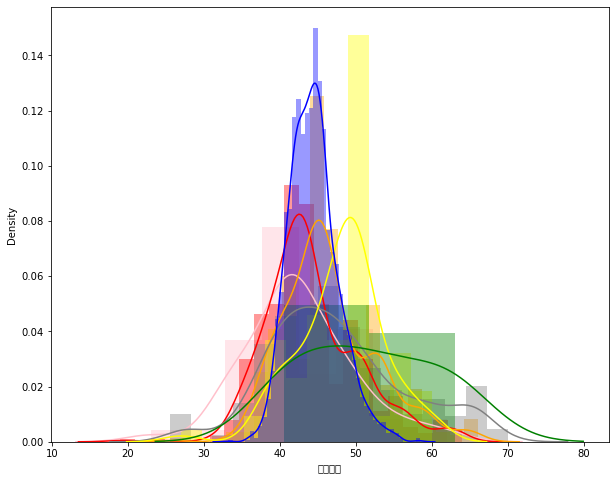

In [27]:
fig, ax = plt.subplots(figsize=(10,8))

sns.distplot(dress_XS.query("columns == '가슴단면'")['measures'], color='pink')
sns.distplot(dress_S.query("columns == '가슴단면'")['measures'], color='red')
sns.distplot(dress_M.query("columns == '가슴단면'")['measures'], color='orange')
sns.distplot(dress_Free.query("columns == '가슴단면'")['measures'], color='gray')
sns.distplot(dress_L.query("columns == '가슴단면'")['measures'], color='yellow')
sns.distplot(dress_XL.query("columns == '가슴단면'")['measures'], color='green')
sns.distplot(dt_chest_2020['가슴단면'], color='blue')

#plt.savefig('mini_dress_total_length.png')

### ⑤ pie chart (무신사 사이즈 평균값을 기준으로 사이즈 코리아 데이터를 나눔)

In [28]:
print('XS_가슴단면:', np.round(dress_XS.query("columns == '가슴단면'")['measures'].mean(), 2))
print('S_가슴단면:', np.round(dress_S.query("columns == '가슴단면'")['measures'].mean(), 2))
print('M_가슴단면:', np.round(dress_M.query("columns == '가슴단면'")['measures'].mean(), 2))
print('Free_가슴단면:', np.round(dress_Free.query("columns == '가슴단면'")['measures'].mean(), 2))
print('L_가슴단면:', np.round(dress_L.query("columns == '가슴단면'")['measures'].mean(), 2))
print('XL_가슴단면:', np.round(dress_XL.query("columns == '가슴단면'")['measures'].mean(), 2))

XS_가슴단면: 42.48
S_가슴단면: 44.19
M_가슴단면: 46.41
Free_가슴단면: 47.3
L_가슴단면: 48.05
XL_가슴단면: 51.5


In [29]:
dt_chest_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2773 entries, 0 to 2772
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   나이      2773 non-null   int64  
 1   키       2773 non-null   float64
 2   가슴단면    2773 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 65.1 KB


In [30]:
chest_data = list(np.array(dt_chest_2020['가슴단면']))
chest_data

[40.2,
 48.95,
 43.2,
 44.5,
 43.25,
 44.5,
 42.650000000000006,
 39.150000000000006,
 45.1,
 54.650000000000006,
 50.150000000000006,
 42.0,
 39.25,
 40.0,
 48.25,
 39.0,
 42.400000000000006,
 44.800000000000004,
 41.5,
 44.650000000000006,
 43.150000000000006,
 45.150000000000006,
 46.0,
 42.45,
 42.400000000000006,
 40.650000000000006,
 48.6,
 46.45,
 40.550000000000004,
 44.35,
 40.85,
 42.95,
 42.0,
 49.5,
 41.800000000000004,
 50.150000000000006,
 42.2,
 41.0,
 45.5,
 44.400000000000006,
 42.85,
 44.650000000000006,
 41.150000000000006,
 42.050000000000004,
 40.75,
 45.1,
 42.5,
 39.7,
 42.400000000000006,
 46.95,
 39.900000000000006,
 39.800000000000004,
 41.050000000000004,
 44.35,
 44.400000000000006,
 41.85,
 44.35,
 43.400000000000006,
 40.800000000000004,
 37.9,
 46.35,
 51.400000000000006,
 43.550000000000004,
 44.900000000000006,
 45.400000000000006,
 42.25,
 44.800000000000004,
 44.85,
 47.400000000000006,
 40.5,
 43.0,
 45.85,
 41.1,
 39.550000000000004,
 45.95,
 40.1,


XS_가슴단면: 42.48<br>
S_가슴단면: 44.19<br>
M_가슴단면: 46.41<br>
Free_가슴단면: 47.3<br>
L_가슴단면: 48.05<br>
XL_가슴단면: 51.5

In [31]:
#수정수정수정
dt_chest_2020['size'] = np.random.randint(2773)
size_lst = []

for chest in chest_data:
    if chest <= 42.48:
        size_lst.append('XS')
    
    elif chest <= 44.19:
        size_lst.append('S')
        
    elif chest <= 46.41:
        size_lst.append('M')
        
    elif chest <= 47.3:
        size_lst.append('Free')
        
    elif chest <= 48.05:
        size_lst.append('L')
        
    else:
        size_lst.append('XL')
        
#print(size_lst)
#print()

dt_chest_2020['size'] = size_lst

dt_chest_2020

,나이,키,가슴단면,size
0,20,162.4,40.20,XS
1,20,165.3,48.95,XL
2,20,168.5,43.20,S
3,20,158.6,44.50,M
4,20,156.1,43.25,S
...,...,...,...,...
2768,69,170.0,43.75,S
2769,69,156.0,50.00,XL
2770,69,153.8,46.35,M
2771,69,153.1,48.85,XL


In [32]:
dt_chest_2020['size'].value_counts()

XS      800
M       776
S       562
XL      357
Free    151
L       127
Name: size, dtype: int64

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


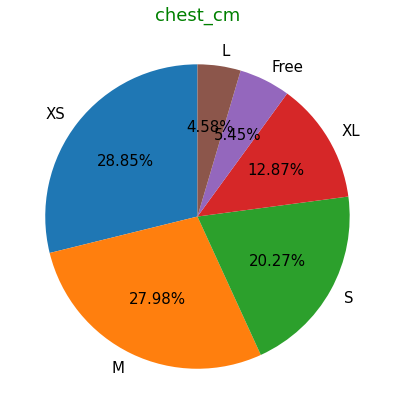

<Figure size 864x648 with 0 Axes>

In [34]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(dt_chest_2020['size'].value_counts(), labels=('XS', 'M', 'S', 'XL', 'Free', 'L'), startangle=90, autopct='%.2f%%')

# 라벨, 타이틀 달기
plt.title('chest_cm', fontsize=18, color='g')

#plt.legend(['XS', 'M', 'S', 'XL', 'Free', 'L'], loc='upper right')

plt.rc('font', size=15)

plt.show()

plt.savefig('sizekorea_chest_cm.png')

## 3) 사이즈코리아 데이터 군집화 (K-평균)
features : 키, 어깨너비, 가슴둘레, 허리둘레, 엉덩이둘레<br>
'2020_size_measures.csv' 파일은 20세 이상 성인에 대한 데이터이다<br>
002. 키 , 059. 어깨사이길이 , 041. 가슴둘레 , 045. 허리둘레 , 048. 엉덩이둘레 ,

In [4]:
dt_2020 = pd.read_csv("C:/Users/admin/#실습(221031~221111)/사이즈코리아/2020_size_measures.csv").query("성별 == '여'")
dt_2020[:5]

C:\Users\admin\AppData\Local\Temp\ipykernel_2752\831315171.py:1: DtypeWarning: Columns (8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  dt_2020 = pd.read_csv("C:/Users/admin/#실습(221031~221111)/사이즈코리아/2020_size_measures.csv").query("성별 == '여'")


,Unnamed: 0,HUMAN_ID,성별,조사년도,조사일,나이,측정지,측정복\n젖가슴둘레,측정복\n상의,측정복\n배꼽수준허리둘레,...,128. 배꼽수준앞중심길이,129. 배꼽수준등길이,130. 목뒤젖꼭지길이,131. 목뒤젖꼭지허리둘레선길이,132. 배꼽수준샅앞뒤길이,133. 앉은눈높이,134. 앉은목뒤높이,135. 앉은어깨높이,136. 앉은팔꿈치높이(팔굽힌),137. 위팔수직길이(팔굽힌)
3,4,20_F_1465,여,2020,1116,42,서울/경기/강원,86.0,85XL,88.0,...,449,453.0,356.5,546.5,882,796,659,626.0,294.0,332.0
4,5,20_F_1467,여,2020,1116,42,서울/경기/강원,73.6,75M,74.5,...,360,391.0,331.5,477.5,731,738,592,544.0,234.0,310.0
5,6,20_F_1477,여,2020,1116,40,서울/경기/강원,74.3,75M,77.0,...,372,405.0,326.5,488.5,749,738,601,552.0,203.0,349.0
6,7,20_F_1486,여,2020,1117,43,서울/경기/강원,77.5,80L,78.0,...,434,428.0,331.5,517.5,741,753,611,581.0,268.0,313.0
7,8,20_F_1490,여,2020,1117,40,서울/경기/강원,80.0,80L,80.0,...,405,415.0,333.5,527.5,696,716,578,544.0,245.0,299.0


In [5]:
dt_2020.shape

(2773, 148)

In [6]:
#002. 키 , 059. 어깨사이길이 , 041. 가슴둘레 , 045. 허리둘레 , 048. 엉덩이둘레
dt_2020['키'] = dt_2020.loc[:, '002. 키 '] * 0.1
dt_2020['어깨너비'] = dt_2020.loc[:, '059. 어깨사이길이 '] * 0.1
dt_2020['가슴단면'] = dt_2020.loc[:, '041. 가슴둘레 '] * 0.05
dt_2020['허리단면'] = dt_2020.loc[:, '045. 허리둘레 '] * 0.05
dt_2020['엉덩이단면'] = dt_2020.loc[:, '048. 엉덩이둘레 '] * 0.05

In [7]:
dt_2020.loc[:, ['키', '어깨너비', '가슴단면', '허리단면', '엉덩이단면']].reset_index()

,index,키,어깨너비,가슴단면,허리단면,엉덩이단면
0,3,168.5,38.6,49.65,44.25,49.90
1,4,160.2,37.5,40.90,35.90,46.10
2,5,164.2,39.5,41.95,35.55,44.70
3,6,158.9,36.6,43.35,36.85,46.40
4,7,153.1,37.7,45.10,40.80,45.45
...,...,...,...,...,...,...
2768,5069,159.7,35.8,41.60,35.95,46.10
2769,5070,154.8,40.0,39.45,33.95,43.35
2770,5071,164.5,38.0,47.10,41.45,52.95
2771,5082,163.5,40.5,43.40,37.70,49.40


In [8]:
dt_2020_df = dt_2020.loc[:, ['키', '어깨너비', '가슴단면', '허리단면', '엉덩이단면']].reset_index().iloc[:, 1:]
dt_2020_df

,키,어깨너비,가슴단면,허리단면,엉덩이단면
0,168.5,38.6,49.65,44.25,49.90
1,160.2,37.5,40.90,35.90,46.10
2,164.2,39.5,41.95,35.55,44.70
3,158.9,36.6,43.35,36.85,46.40
4,153.1,37.7,45.10,40.80,45.45
...,...,...,...,...,...
2768,159.7,35.8,41.60,35.95,46.10
2769,154.8,40.0,39.45,33.95,43.35
2770,164.5,38.0,47.10,41.45,52.95
2771,163.5,40.5,43.40,37.70,49.40


In [9]:
dt_2020_df.describe()
dt_2020_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2773 entries, 0 to 2772
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   키       2773 non-null   float64
 1   어깨너비    2773 non-null   float64
 2   가슴단면    2773 non-null   float64
 3   허리단면    2773 non-null   float64
 4   엉덩이단면   2773 non-null   float64
dtypes: float64(5)
memory usage: 108.4 KB


#### 이상치 제거

<AxesSubplot:ylabel='어깨너비'>

C:\Users\admin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\admin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44648 (\N{HANGUL SYLLABLE GGAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\admin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\admin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


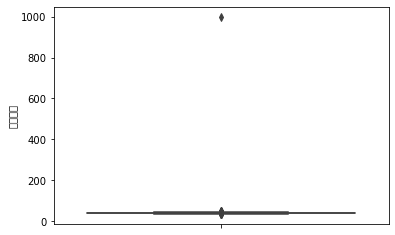

In [10]:
sns.boxplot(data = dt_2020_df, y = '어깨너비')

In [11]:
dt_2020_df[['어깨너비']].sort_values(by='어깨너비', ascending=False)

,어깨너비
884,999.9
2057,49.5
123,49.1
1996,49.0
2647,47.5
...,...
757,33.8
1092,33.7
626,33.4
1246,33.2


In [12]:
dt_2020_df.drop([884, 1], axis=0, inplace=True)

In [13]:
dt_2020_df = dt_2020_df.reset_index().iloc[:, 1:]
dt_2020_df

,키,어깨너비,가슴단면,허리단면,엉덩이단면
0,168.5,38.6,49.65,44.25,49.90
1,164.2,39.5,41.95,35.55,44.70
2,158.9,36.6,43.35,36.85,46.40
3,153.1,37.7,45.10,40.80,45.45
4,153.8,39.4,43.75,38.50,45.65
...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10
2767,154.8,40.0,39.45,33.95,43.35
2768,164.5,38.0,47.10,41.45,52.95
2769,163.5,40.5,43.40,37.70,49.40


In [14]:
dt_2020_df.to_csv("C:/Users/admin/#실습(221031~221111)/sizekorea_2020.csv")

### * 군집화 함수

In [45]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

In [46]:
def visualize_silhouette(cluster_lists, X_features): 
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [47]:
dt_2020_km = dt_2020_df.copy()

C:\Users\AB350\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\AB350\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\AB350\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\AB350\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Win

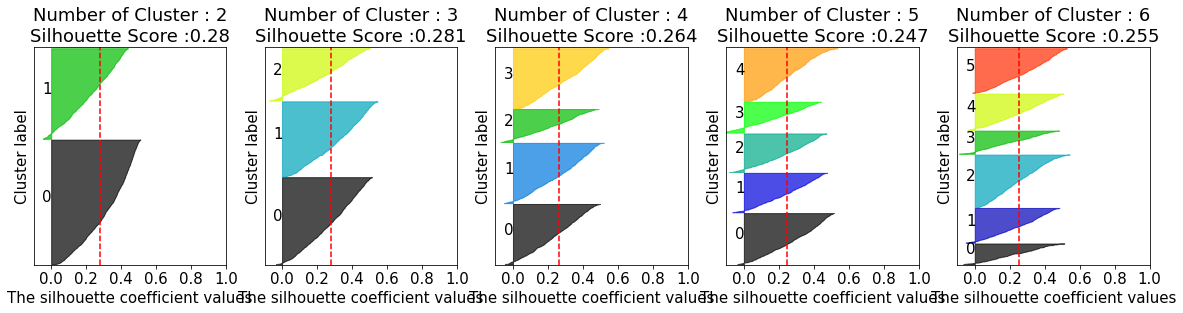

In [48]:
cluster_lists = [2,3,4,5,6]
X_features = dt_2020_km

visualize_silhouette(cluster_lists, X_features)

#plt.savefig('clustering_result.jpg')

#### n_clusters = 6

In [49]:
#n_clusters = 6
clusterer = KMeans(n_clusters = 6, max_iter=500, random_state=0)
cluster_labels = clusterer.fit(dt_2020_km)
cluster_labels.labels_

C:\Users\AB350\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


array([0, 4, 2, ..., 0, 4, 1])

In [50]:
dt_2020_km['cluster=6'] = cluster_labels.labels_
dt_2020_km

,키,어깨너비,가슴단면,허리단면,엉덩이단면,cluster=6
0,168.5,38.6,49.65,44.25,49.90,0
1,164.2,39.5,41.95,35.55,44.70,4
2,158.9,36.6,43.35,36.85,46.40,2
3,153.1,37.7,45.10,40.80,45.45,1
4,153.8,39.4,43.75,38.50,45.65,1
...,...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10,5
2767,154.8,40.0,39.45,33.95,43.35,5
2768,164.5,38.0,47.10,41.45,52.95,0
2769,163.5,40.5,43.40,37.70,49.40,4


각 데이터 포인트의 실루엣 계수<br>
sklearn.metrics.silhouette_samples(X, labels, metric='euclidean', **kwds)<br>
(X : X feature 데이터 세트, labels : 군집 레이블 값)<br>

전체 데이터의 실루엣 계수 값의 평균<br>
sklearn.metrics.silhouette_score(X, labels, metric='euclidean', sample_size=None, **kwds)

In [51]:
#각 데이터 포인트의 실루엣 계수
sil_values = silhouette_samples(np.array(dt_2020_km), dt_2020_km['cluster=6'])

#모든 데이터의 평균 실루엣 계수
sil_avg = silhouette_score(np.array(dt_2020_km), dt_2020_km['cluster=6']).round(3)

print('sil_values:', sil_values)
print('sil_avg:', sil_avg)

sil_values: [0.40130349 0.25008209 0.17208517 ... 0.21351107 0.02669861 0.28882629]
sil_avg: 0.286


#### n_clusters = 5

In [52]:
#n_clusters = 5
clusterer = KMeans(n_clusters = 5, max_iter=500, random_state=0)
cluster_labels = clusterer.fit(dt_2020_km)
cluster_labels.labels_

C:\Users\AB350\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


array([3, 4, 1, ..., 3, 4, 2])

In [53]:
dt_2020_km['cluster=5'] = cluster_labels.labels_
dt_2020_km

,키,어깨너비,가슴단면,허리단면,엉덩이단면,cluster=6,cluster=5
0,168.5,38.6,49.65,44.25,49.90,0,3
1,164.2,39.5,41.95,35.55,44.70,4,4
2,158.9,36.6,43.35,36.85,46.40,2,1
3,153.1,37.7,45.10,40.80,45.45,1,2
4,153.8,39.4,43.75,38.50,45.65,1,2
...,...,...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10,5,0
2767,154.8,40.0,39.45,33.95,43.35,5,0
2768,164.5,38.0,47.10,41.45,52.95,0,3
2769,163.5,40.5,43.40,37.70,49.40,4,4


각 데이터 포인트의 실루엣 계수<br>
sklearn.metrics.silhouette_samples(X, labels, metric='euclidean', **kwds)<br>
(X : X feature 데이터 세트, labels : 군집 레이블 값)<br>

전체 데이터의 실루엣 계수 값의 평균<br>
sklearn.metrics.silhouette_score(X, labels, metric='euclidean', sample_size=None, **kwds)

In [54]:
#각 데이터 포인트의 실루엣 계수
sil_values = silhouette_samples(np.array(dt_2020_km), dt_2020_km['cluster=5'])

#모든 데이터의 평균 실루엣 계수
sil_avg = silhouette_score(np.array(dt_2020_km), dt_2020_km['cluster=5']).round(3)

print('sil_values:', sil_values)
print('sil_avg:', sil_avg)

sil_values: [ 1.72920696e-01  2.83550295e-01  1.53035285e-01 ... -1.49272066e-04
  1.04492913e-01  3.00883547e-01]
sil_avg: 0.289


#### n_clusters = 4

In [55]:
#n_clusters = 4
clusterer = KMeans(n_clusters = 4, max_iter=500, random_state=0)
cluster_labels = clusterer.fit(dt_2020_km)
cluster_labels.labels_

C:\Users\AB350\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


array([1, 2, 0, ..., 1, 2, 3])

In [56]:
dt_2020_km['cluster=4'] = cluster_labels.labels_
dt_2020_km

,키,어깨너비,가슴단면,허리단면,엉덩이단면,cluster=6,cluster=5,cluster=4
0,168.5,38.6,49.65,44.25,49.90,0,3,1
1,164.2,39.5,41.95,35.55,44.70,4,4,2
2,158.9,36.6,43.35,36.85,46.40,2,1,0
3,153.1,37.7,45.10,40.80,45.45,1,2,3
4,153.8,39.4,43.75,38.50,45.65,1,2,3
...,...,...,...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10,5,0,0
2767,154.8,40.0,39.45,33.95,43.35,5,0,0
2768,164.5,38.0,47.10,41.45,52.95,0,3,1
2769,163.5,40.5,43.40,37.70,49.40,4,4,2


In [57]:
#각 데이터 포인트의 실루엣 계수
sil_values = silhouette_samples(np.array(dt_2020_km), dt_2020_km['cluster=4'])

#모든 데이터의 평균 실루엣 계수
sil_avg = silhouette_score(np.array(dt_2020_km), dt_2020_km['cluster=4']).round(3)

print('sil_values:', sil_values)
print('sil_avg:', sil_avg)

sil_values: [0.16378952 0.25359344 0.19733647 ... 0.13008229 0.40422279 0.48426541]
sil_avg: 0.301


### * cluster=6

In [58]:
dt_2020_km.groupby('cluster=6')[['키', '어깨너비', '가슴단면', '허리단면', '엉덩이단면']].mean().round(2)

,키,어깨너비,가슴단면,허리단면,엉덩이단면
cluster=6,,,,,
0,165.64,42.18,48.46,43.65,51.58
1,152.21,38.60,44.39,39.83,45.69
2,159.79,39.83,44.72,39.12,47.31
3,156.84,40.84,49.22,46.31,50.49
4,166.75,40.71,42.97,35.99,46.77
5,158.12,38.68,40.98,33.90,44.26


In [59]:
dt_2020_km['cluster=6'].value_counts()

2    687
5    583
4    474
1    455
3    303
0    269
Name: cluster=6, dtype: int64

0 : 5-6-5-5-6 => 27/5.4/6 (269, XL)<br>
1 : 1-1-3-4-2 => 11/2.2/2 (455, S)<br>
2 : 4-3-4-3-4 => 18/3.6/4 (687, F)<br>
3 : 2-5-6-6-5 => 24/4.8/5 (303, L)<br>
4 : 6-4-2-2-3 => 17/3.4/3 (474, M)<br>
5 : 3-2-1-1-1 => 8/1.6/1 (583, XS)

#### 0 -> XL / 1 -> S / 2 -> Free(M~L) / 3 -> L / 4 -> M / 5 -> XS (n_clusters = 6)

0 : 5-6-5-5-6 => 27/5.4/6 (269, XL)<br>
1 : 1-1-3-4-2 => 11/2.2/2 (455, S)<br>
2 : 4-3-4-3-4 => 18/3.6/4 (687, F)<br>
3 : 2-5-6-6-5 => 24/4.8/5 (303, L)<br>
4 : 6-4-2-2-3 => 17/3.4/3 (474, M)<br>
5 : 3-2-1-1-1 => 8/1.6/1 (583, XS)

In [60]:
dt_2020_km['size(6)'] = np.random.randint(2771)
size_li = []

for i in range(2771):
    if dt_2020_km['cluster=6'][i] == 0:
        size_li.append('XL')
        
    elif dt_2020_km['cluster=6'][i] == 1:
        size_li.append('S')
        
    elif dt_2020_km['cluster=6'][i] == 2:
        size_li.append('Free')
        
    elif dt_2020_km['cluster=6'][i] == 3:
        size_li.append('L')
        
    elif dt_2020_km['cluster=6'][i] == 4:
        size_li.append('M')
        
    else:
        size_li.append('XS')
        
#print(size_lst)
#print()

dt_2020_km['size(6)'] = size_li

dt_2020_km

,키,어깨너비,가슴단면,허리단면,엉덩이단면,cluster=6,cluster=5,cluster=4,size(6)
0,168.5,38.6,49.65,44.25,49.90,0,3,1,XL
1,164.2,39.5,41.95,35.55,44.70,4,4,2,M
2,158.9,36.6,43.35,36.85,46.40,2,1,0,Free
3,153.1,37.7,45.10,40.80,45.45,1,2,3,S
4,153.8,39.4,43.75,38.50,45.65,1,2,3,S
...,...,...,...,...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10,5,0,0,XS
2767,154.8,40.0,39.45,33.95,43.35,5,0,0,XS
2768,164.5,38.0,47.10,41.45,52.95,0,3,1,XL
2769,163.5,40.5,43.40,37.70,49.40,4,4,2,M


In [61]:
dt_2020_km['size(6)'].value_counts()

Free    687
XS      583
M       474
S       455
L       303
XL      269
Name: size(6), dtype: int64

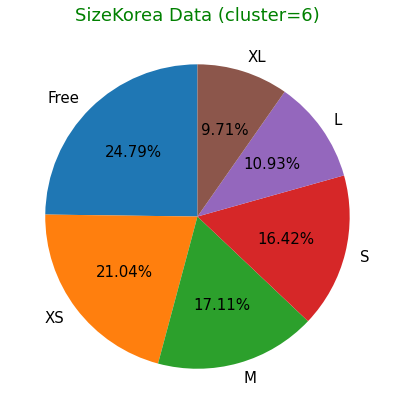

In [62]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(dt_2020_km['size(6)'].value_counts(), labels=('Free', 'XS', 'M', 'S', 'L', 'XL'), startangle=90, autopct='%.2f%%')

# 라벨, 타이틀 달기
plt.title('SizeKorea Data (cluster=6)', fontsize=18, color='g')

#plt.legend(['M','L', 'S', 'XL'], loc='upper right')

plt.rc('font', size=15)

plt.show()

#plt.savefig('SizeKorea_Data(cluster=6).jpg')

### * cluster=4

In [63]:
dt_2020_km.groupby('cluster=4')[['키', '어깨너비', '가슴단면', '허리단면', '엉덩이단면']].mean().round(2)

,키,어깨너비,가슴단면,허리단면,엉덩이단면
cluster=4,,,,,
0,158.32,38.74,41.22,34.21,44.44
1,161.48,41.56,49.07,45.16,51.36
2,165.58,40.67,43.67,37.01,47.27
3,154.87,39.19,44.95,40.32,46.57


In [64]:
dt_2020_km['cluster=4'].value_counts()

3    894
2    712
0    677
1    488
Name: cluster=4, dtype: int64

0 : 2-1-1-1-1 => 1 (677, S)<br>
1 : 3-4-4-4-4 => 4 (488, XL)<br>
2 : 4-3-2-2-3 => 3 (712, L)<br>
3 : 1-2-3-3-2 => 2 (894, M)

In [65]:
dt_2020_km.groupby('cluster=4')[['키', '어깨너비', '가슴단면', '허리단면', '엉덩이단면']].agg([('max', max), ('min', min)])

키         어깨너비         가슴단면          허리단면         엉덩이단면       
             max    min   max   min    max    min    max    min    max    min
cluster=4                                                                    
0          165.5  143.8  44.5  33.4  45.85  35.95  39.55  28.60  49.70  37.50
1          174.4  149.7  49.1  36.5  58.40  44.15  58.90  38.65  68.45  44.95
2          181.0  159.8  49.5  35.4  49.05  37.70  43.50  30.55  54.30  41.60
3          162.0  140.0  47.5  33.0  52.35  33.20  50.60  32.90  55.05  39.95

#### 0 -> S / 1 -> XL / 2 -> L / 3 -> M (n_clusters = 4)

0 : 2-1-1-1-1 => 1 (677, S)<br>
1 : 3-4-4-4-4 => 4 (488, XL)<br>
2 : 4-3-2-2-3 => 3 (712, L)<br>
3 : 1-2-3-3-2 => 2 (894, M)

In [66]:
dt_2020_km['size(4)'] = np.random.randint(2771)
size_li = []

for i in range(2771):
    if dt_2020_km['cluster=4'][i] == 0:
        size_li.append('S')
        
    elif dt_2020_km['cluster=4'][i] == 1:
        size_li.append('XL')
        
    elif dt_2020_km['cluster=4'][i] == 2:
        size_li.append('L')
        
    else:
        size_li.append('M')
        
#print(size_lst)
#print()

dt_2020_km['size(4)'] = size_li

dt_2020_km

,키,어깨너비,가슴단면,허리단면,엉덩이단면,cluster=6,cluster=5,cluster=4,size(6),size(4)
0,168.5,38.6,49.65,44.25,49.90,0,3,1,XL,XL
1,164.2,39.5,41.95,35.55,44.70,4,4,2,M,L
2,158.9,36.6,43.35,36.85,46.40,2,1,0,Free,S
3,153.1,37.7,45.10,40.80,45.45,1,2,3,S,M
4,153.8,39.4,43.75,38.50,45.65,1,2,3,S,M
...,...,...,...,...,...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10,5,0,0,XS,S
2767,154.8,40.0,39.45,33.95,43.35,5,0,0,XS,S
2768,164.5,38.0,47.10,41.45,52.95,0,3,1,XL,XL
2769,163.5,40.5,43.40,37.70,49.40,4,4,2,M,L


In [67]:
dt_2020_km['size(4)'].value_counts()

M     894
L     712
S     677
XL    488
Name: size(4), dtype: int64

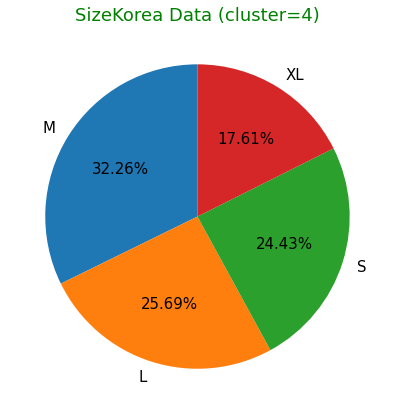

In [68]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(dt_2020_km['size(4)'].value_counts(), labels=('M', 'L', 'S', 'XL'), startangle=90, autopct='%.2f%%')

# 라벨, 타이틀 달기
plt.title('SizeKorea Data (cluster=4)', fontsize=18, color='g')

#plt.legend(['M','L', 'S', 'XL'], loc='upper right')

plt.rc('font', size=15)

plt.show()

#plt.savefig('SizeKorea_Data(cluster=4).jpg')

## 4) 사이즈코리아 데이터 군집화 (평균이동)
features : 키, 어깨너비, 가슴둘레, 허리둘레, 엉덩이둘레<br>
'2020_size_measures.csv' 파일은 20세 이상 성인에 대한 데이터이다<br>
002. 키 , 059. 어깨사이길이 , 041. 가슴둘레 , 045. 허리둘레 , 048. 엉덩이둘레 ,

In [119]:
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

In [120]:
dt_2020_ms = dt_2020_df.copy()
dt_2020_ms

,키,어깨사이길이,가슴둘레/2,허리둘레/2,엉덩이둘레/2
0,168.5,38.6,49.65,44.25,49.90
1,164.2,39.5,41.95,35.55,44.70
2,158.9,36.6,43.35,36.85,46.40
3,153.1,37.7,45.10,40.80,45.45
4,153.8,39.4,43.75,38.50,45.65
...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10
2767,154.8,40.0,39.45,33.95,43.35
2768,164.5,38.0,47.10,41.45,52.95
2769,163.5,40.5,43.40,37.70,49.40


### * 최적의 대역폭 계산

In [122]:
bandwidth = estimate_bandwidth(dt_2020_ms)
print('bandwidth 값:', round(bandwidth, 3))

bandwidth 값: 8.422


In [123]:
best_bandwidth = estimate_bandwidth(dt_2020_ms)

meanshift = MeanShift(bandwidth=best_bandwidth)

cluster_labels = meanshift.fit_predict(dt_2020_ms)

dt_2020_ms['meanshift_label'] = cluster_labels

print(dt_2020_ms['meanshift_label'].value_counts())

centers = meanshift.cluster_centers_

unique_labels = np.unique(cluster_labels)

0    2730
1      37
2       4
Name: meanshift_label, dtype: int64


In [124]:
dt_2020_ms.groupby('meanshift_label')[['키', '어깨사이길이', '가슴둘레/2', '허리둘레/2', '엉덩이둘레/2']].mean().round(2)

,키,어깨사이길이,가슴둘레/2,허리둘레/2,엉덩이둘레/2
meanshift_label,,,,,
0,159.58,39.82,44.31,38.65,46.94
1,164.50,43.80,53.80,51.11,56.63
2,149.25,38.38,41.26,46.70,49.81


In [125]:
dt_2020_ms.groupby('meanshift_label')[['키', '어깨사이길이', '가슴둘레/2', '허리둘레/2', '엉덩이둘레/2']].agg([('max', max), ('min', min)])

키        어깨사이길이       가슴둘레/2        허리둘레/2       엉덩이둘레/2  \
                   max    min    max   min    max    min    max   min     max   
meanshift_label                                                                 
0                181.0  140.0   49.5  33.0   55.5  35.95  53.65  28.6   57.60   
1                173.6  152.5   49.1  40.4   58.4  50.15  58.90  42.3   68.45   
2                156.9  140.4   40.5  36.5   45.9  33.20  50.60  43.5   55.05   

                        
                   min  
meanshift_label         
0                37.50  
1                51.35  
2                45.00

## 5) 사이즈코리아 데이터 군집화 (GMM)
features : 키, 어깨너비, 가슴둘레, 허리둘레, 엉덩이둘레<br>
'2020_size_measures.csv' 파일은 20세 이상 성인에 대한 데이터이다<br>
002. 키 , 059. 어깨사이길이 , 041. 가슴둘레 , 045. 허리둘레 , 048. 엉덩이둘레 ,

In [15]:
from sklearn.mixture import GaussianMixture

In [17]:
dt_2020_df = pd.read_csv("C:/Users/admin/#실습(221031~221111)/sizekorea_2020.csv").iloc[:, 1:]
dt_2020_df

,키,어깨너비,가슴단면,허리단면,엉덩이단면
0,168.5,38.6,49.65,44.25,49.90
1,164.2,39.5,41.95,35.55,44.70
2,158.9,36.6,43.35,36.85,46.40
3,153.1,37.7,45.10,40.80,45.45
4,153.8,39.4,43.75,38.50,45.65
...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10
2767,154.8,40.0,39.45,33.95,43.35
2768,164.5,38.0,47.10,41.45,52.95
2769,163.5,40.5,43.40,37.70,49.40


### * n_components=6

In [18]:
dt_2020_gm6 = dt_2020_df.copy()
dt_2020_gm6

,키,어깨너비,가슴단면,허리단면,엉덩이단면
0,168.5,38.6,49.65,44.25,49.90
1,164.2,39.5,41.95,35.55,44.70
2,158.9,36.6,43.35,36.85,46.40
3,153.1,37.7,45.10,40.80,45.45
4,153.8,39.4,43.75,38.50,45.65
...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10
2767,154.8,40.0,39.45,33.95,43.35
2768,164.5,38.0,47.10,41.45,52.95
2769,163.5,40.5,43.40,37.70,49.40


In [19]:
# gmm으로 군집화
gmm = GaussianMixture(n_components=6, random_state=0).fit(dt_2020_gm6)
gmm_cluster_labels = gmm.predict(dt_2020_gm6)

# 클러스터링 결과 저장
dt_2020_gm6['gmm_cluster=6'] = gmm_cluster_labels

# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인
dt_2020_gm6['gmm_cluster=6'].value_counts()

1    691
3    686
5    461
4    447
2    277
0    209
Name: gmm_cluster=6, dtype: int64

In [20]:
dt_2020_gm6.groupby('gmm_cluster=6')[['키', '어깨너비', '가슴단면', '허리단면', '엉덩이단면']].mean().round(2)

,키,어깨너비,가슴단면,허리단면,엉덩이단면
gmm_cluster=6,,,,,
0,155.06,40.77,48.69,46.20,49.80
1,159.54,39.75,44.99,39.64,47.58
2,164.22,42.18,49.27,45.00,52.11
3,159.09,38.75,41.26,34.10,44.62
4,152.41,38.47,44.45,39.89,45.63
5,166.87,41.31,43.48,36.57,47.10


0 : 2-4-5-6-5 => 22/4.4/5 (209, L)<br>
1 : 4-3-4-3-4 => 18/3.6/3 (691, M)<br>
2 : 5-6-6-5-6 => 28/5.6/6 (277, XL)<br>
3 : 3-2-1-1-1 => 8/1.6/1 (686, XS)<br>
4 : 1-1-3-4-2 => 12/2.4/2 (447, S)<br>
5 : 6-5-2-2-3 => 18/3.6/4 (461, F)

In [21]:
dt_2020_gm6.groupby('gmm_cluster=6')[['키', '어깨너비', '가슴단면', '허리단면', '엉덩이단면']].agg([('max', max), ('min', min)])

키         어깨너비         가슴단면          허리단면         엉덩이단면  \
                 max    min   max   min    max    min    max    min    max   
gmm_cluster=6                                                                
0              162.4  146.2  44.5  35.5  55.70  33.20  55.35  38.95  60.25   
1              166.2  152.0  44.3  33.2  49.20  40.80  44.85  32.60  52.80   
2              174.4  156.8  49.1  37.0  58.40  41.50  58.90  37.95  68.45   
3              166.0  148.5  43.3  33.8  44.85  35.95  37.75  28.60  48.70   
4              160.5  140.0  42.2  33.0  49.40  36.30  46.75  30.80  50.85   
5              181.0  156.7  49.5  33.4  49.05  36.55  42.70  29.20  51.95   

                      
                 min  
gmm_cluster=6         
0              43.45  
1              42.35  
2              45.80  
3              37.50  
4              37.75  
5              40.55

#### 0 -> L / 1 -> M / 2 -> XL / 3 -> XS / 4 -> S / 5 -> Free

In [22]:
dt_2020_gm6

,키,어깨너비,가슴단면,허리단면,엉덩이단면,gmm_cluster=6
0,168.5,38.6,49.65,44.25,49.90,2
1,164.2,39.5,41.95,35.55,44.70,3
2,158.9,36.6,43.35,36.85,46.40,1
3,153.1,37.7,45.10,40.80,45.45,4
4,153.8,39.4,43.75,38.50,45.65,4
...,...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10,3
2767,154.8,40.0,39.45,33.95,43.35,3
2768,164.5,38.0,47.10,41.45,52.95,2
2769,163.5,40.5,43.40,37.70,49.40,1


In [23]:
dt_2020_gm6['size(6)'] = np.random.randint(2771)
size_li = []

for i in range(2771):
    if dt_2020_gm6['gmm_cluster=6'][i] == 0:
        size_li.append('L')
        
    elif dt_2020_gm6['gmm_cluster=6'][i] == 1:
        size_li.append('M')
        
    elif dt_2020_gm6['gmm_cluster=6'][i] == 2:
        size_li.append('XL')
        
    elif dt_2020_gm6['gmm_cluster=6'][i] == 3:
        size_li.append('XS')
        
    elif dt_2020_gm6['gmm_cluster=6'][i] == 4:
        size_li.append('S')
        
    else:
        size_li.append('Free')
        
#print(size_lst)
#print()

dt_2020_gm6['size(6)'] = size_li

dt_2020_gm6

,키,어깨너비,가슴단면,허리단면,엉덩이단면,gmm_cluster=6,size(6)
0,168.5,38.6,49.65,44.25,49.90,2,XL
1,164.2,39.5,41.95,35.55,44.70,3,XS
2,158.9,36.6,43.35,36.85,46.40,1,M
3,153.1,37.7,45.10,40.80,45.45,4,S
4,153.8,39.4,43.75,38.50,45.65,4,S
...,...,...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10,3,XS
2767,154.8,40.0,39.45,33.95,43.35,3,XS
2768,164.5,38.0,47.10,41.45,52.95,2,XL
2769,163.5,40.5,43.40,37.70,49.40,1,M


In [24]:
dt_2020_gm6['size(6)'].value_counts()

M       691
XS      686
Free    461
S       447
XL      277
L       209
Name: size(6), dtype: int64

In [25]:
dt_2020_gm6.to_csv("C:/Users/admin/#실습(221031~221111)/sizekorea_2020_gmm6.csv")

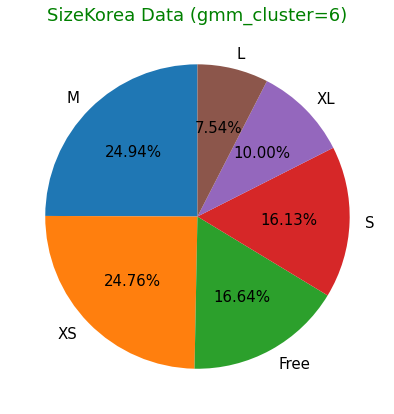

In [27]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(dt_2020_gm6['size(6)'].value_counts(), labels=('M', 'XS', 'Free', 'S', 'XL', 'L'), startangle=90, autopct='%.2f%%')

# 라벨, 타이틀 달기
plt.title('SizeKorea Data (gmm_cluster=6)', fontsize=18, color='g')

#plt.legend(['M','L', 'S', 'XL'], loc='upper right')

plt.rc('font', size=15)

plt.show()

#plt.savefig('SizeKorea_Data(gmm_cluster=6).png')

### * n_components=4

In [28]:
dt_2020_gm4 = dt_2020_df.copy()
dt_2020_gm4

,키,어깨너비,가슴단면,허리단면,엉덩이단면
0,168.5,38.6,49.65,44.25,49.90
1,164.2,39.5,41.95,35.55,44.70
2,158.9,36.6,43.35,36.85,46.40
3,153.1,37.7,45.10,40.80,45.45
4,153.8,39.4,43.75,38.50,45.65
...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10
2767,154.8,40.0,39.45,33.95,43.35
2768,164.5,38.0,47.10,41.45,52.95
2769,163.5,40.5,43.40,37.70,49.40


In [29]:
# gmm으로 군집화
gmm = GaussianMixture(n_components=4, random_state=0).fit(dt_2020_gm4)
gmm_cluster_labels = gmm.predict(dt_2020_gm4)

# 클러스터링 결과 저장
dt_2020_gm4['gmm_cluster=4'] = gmm_cluster_labels

# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인
dt_2020_gm4['gmm_cluster=4'].value_counts()

0    931
3    794
1    705
2    341
Name: gmm_cluster=4, dtype: int64

In [30]:
dt_2020_gm4.groupby('gmm_cluster=4')[['키', '어깨너비', '가슴단면', '허리단면', '엉덩이단면']].mean().round(2)

,키,어깨너비,가슴단면,허리단면,엉덩이단면
gmm_cluster=4,,,,,
0,155.74,39.31,45.28,40.94,46.65
1,165.34,41.06,44.12,37.46,47.78
2,160.78,41.79,49.62,46.08,52.33
3,158.62,38.66,41.50,34.45,44.68


0 : 1-2-3-3-2 => 2 (931, M)<br>
1 : 4-3-2-2-3 => 3 (705, L)<br>
2 : 3-4-4-4-4 => 4 (341, XL)<br>
3 : 2-1-1-1-1 => 1 (794, S)

In [31]:
dt_2020_gm4.groupby('gmm_cluster=4')[['키', '어깨너비', '가슴단면', '허리단면', '엉덩이단면']].agg([('max', max), ('min', min)])

키         어깨너비         가슴단면         허리단면         엉덩이단면  \
                 max    min   max   min    max    min   max    min    max   
gmm_cluster=4                                                               
0              168.9  140.0  45.3  33.0  50.10  36.30  48.6  32.00  51.45   
1              181.0  156.5  49.5  33.8  49.75  37.80  44.9  30.35  53.00   
2              174.4  140.4  49.1  35.5  58.40  33.20  58.9  37.00  68.45   
3              167.6  144.4  43.3  33.4  45.60  35.95  38.7  28.60  49.70   

                      
                 min  
gmm_cluster=4         
0              37.75  
1              41.20  
2              45.00  
3              37.50

#### 0 -> M / 1 -> L / 2 -> XL / 3 -> S

In [32]:
dt_2020_gm4

,키,어깨너비,가슴단면,허리단면,엉덩이단면,gmm_cluster=4
0,168.5,38.6,49.65,44.25,49.90,1
1,164.2,39.5,41.95,35.55,44.70,3
2,158.9,36.6,43.35,36.85,46.40,3
3,153.1,37.7,45.10,40.80,45.45,0
4,153.8,39.4,43.75,38.50,45.65,0
...,...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10,3
2767,154.8,40.0,39.45,33.95,43.35,3
2768,164.5,38.0,47.10,41.45,52.95,1
2769,163.5,40.5,43.40,37.70,49.40,1


In [33]:
dt_2020_gm4['size(4)'] = np.random.randint(2771)
size_li = []

for i in range(2771):
    if dt_2020_gm4['gmm_cluster=4'][i] == 0:
        size_li.append('M')
        
    elif dt_2020_gm4['gmm_cluster=4'][i] == 1:
        size_li.append('L')
        
    elif dt_2020_gm4['gmm_cluster=4'][i] == 2:
        size_li.append('XL')
        
    else:
        size_li.append('S')
        
#print(size_lst)
#print()

dt_2020_gm4['size(4)'] = size_li

dt_2020_gm4

,키,어깨너비,가슴단면,허리단면,엉덩이단면,gmm_cluster=4,size(4)
0,168.5,38.6,49.65,44.25,49.90,1,L
1,164.2,39.5,41.95,35.55,44.70,3,S
2,158.9,36.6,43.35,36.85,46.40,3,S
3,153.1,37.7,45.10,40.80,45.45,0,M
4,153.8,39.4,43.75,38.50,45.65,0,M
...,...,...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10,3,S
2767,154.8,40.0,39.45,33.95,43.35,3,S
2768,164.5,38.0,47.10,41.45,52.95,1,L
2769,163.5,40.5,43.40,37.70,49.40,1,L


In [34]:
dt_2020_gm4['size(4)'].value_counts()

M     931
S     794
L     705
XL    341
Name: size(4), dtype: int64

In [35]:
dt_2020_gm4.to_csv("C:/Users/admin/#실습(221031~221111)/sizekorea_2020_gmm4.csv")

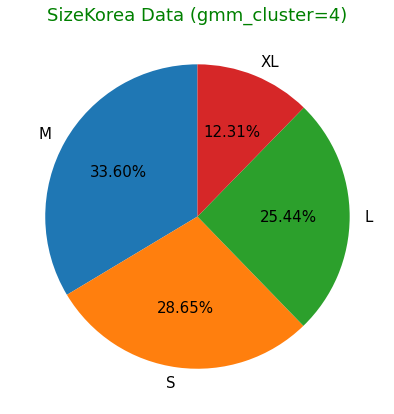

In [36]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(dt_2020_gm4['size(4)'].value_counts(), labels=('M', 'S', 'L', 'XL'), startangle=90, autopct='%.2f%%')

# 라벨, 타이틀 달기
plt.title('SizeKorea Data (gmm_cluster=4)', fontsize=18, color='g')

#plt.legend(['M','L', 'S', 'XL'], loc='upper right')

plt.rc('font', size=15)

plt.show()

#plt.savefig('SizeKorea_Data(gmm_cluster=4).png')

## 6) 사이즈코리아 데이터 군집화 (DBSCAN)
features : 키, 어깨너비, 가슴둘레, 허리둘레, 엉덩이둘레<br>
'2020_size_measures.csv' 파일은 20세 이상 성인에 대한 데이터이다<br>
002. 키 , 059. 어깨사이길이 , 041. 가슴둘레 , 045. 허리둘레 , 048. 엉덩이둘레 ,

In [135]:
from sklearn.cluster import DBSCAN

In [136]:
dt_2020_db = dt_2020_df.copy()
dt_2020_db

,키,어깨사이길이,가슴둘레/2,허리둘레/2,엉덩이둘레/2
0,168.5,38.6,49.65,44.25,49.90
1,164.2,39.5,41.95,35.55,44.70
2,158.9,36.6,43.35,36.85,46.40
3,153.1,37.7,45.10,40.80,45.45
4,153.8,39.4,43.75,38.50,45.65
...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10
2767,154.8,40.0,39.45,33.95,43.35
2768,164.5,38.0,47.10,41.45,52.95
2769,163.5,40.5,43.40,37.70,49.40


In [137]:
# 주변 영역 반경 = 0.6, 최소 데이터 개수 = 8
dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(dt_2020_db)

# 군집화된 레이블 값 저장
dt_2020_db['dbscan_cluster'] = dbscan_labels

# 예측 비교
dt_2020_db['dbscan_cluster'].value_counts()

-1    2771
Name: dbscan_cluster, dtype: int64

In [138]:
# 주변 영역 반경 = 0.8, 최소 데이터 개수 = 8
dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(dt_2020_db)

# 군집화된 레이블 값 저장
dt_2020_db['dbscan_cluster'] = dbscan_labels

# 예측 비교
dt_2020_db['dbscan_cluster'].value_counts()

-1    2771
Name: dbscan_cluster, dtype: int64

In [139]:
# 주변 영역 반경 = 0.3, 최소 데이터 개수 = 3
dbscan = DBSCAN(eps=0.3, min_samples=3, metric='euclidean')
dbscan_labels = dbscan.fit_predict(dt_2020_db)

# 군집화된 레이블 값 저장
dt_2020_db['dbscan_cluster'] = dbscan_labels

# 예측 비교
dt_2020_db['dbscan_cluster'].value_counts()

-1    2771
Name: dbscan_cluster, dtype: int64

## 7) 웹크롤링 (브랜드명, 상품명 추가)

### * 원피스 전체 상품 크롤링 (+브랜드명, 상품명)
모든 측정 데이터(총장, 어깨너비, 가슴단면, 소매길이, 허리단면, 엉덩이단면)를 갖고 있는 상품만 가져온다

In [3]:
#1~20페이지 내의 상품 접속 '링크만' 추출
#soup.select(selector= '#searchList > li:nth-child(1) > div.li_inner > div.article_info > p.list_info > a')

dresses = []

for i in range(1, 21):
    url = f'https://www.musinsa.com/categories/item/020?d_cat_cd=020&brand=&list_kind=small&sort=sale_high&sub_sort=3m&page={i}&display_cnt=90&group_sale=&exclusive_yn=&sale_goods=&timesale_yn=&ex_soldout=&kids=&color=&price1=&price2=&shoeSizeOption=&tags=&campaign_id=&includeKeywords=&measure='
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'html.parser')
    #사이트 내 상품명 & 링크
    products = soup.select(selector = 'p.list_info > a')
    
    #링크만 추출
    for product in products:
        dresses.append(product['href'])

dress_links = []

#링크 모음 리스트 dresses 내에 있는 링크에 대한 조건문
for dress in dresses:
    if 'http:' in dress:
        pass
    elif 'https:' in dress:
        pass
    else:
        dress = 'http:' + dress
        dress_links.append(dress)
        
dress_links

['http://www.musinsa.com/app/goods/2714524?loc=goods_rank',
 'http://www.musinsa.com/app/goods/2882890?loc=goods_rank',
 'http://www.musinsa.com/app/goods/2836338?loc=goods_rank',
 'http://www.musinsa.com/app/goods/2872159?loc=goods_rank',
 'http://www.musinsa.com/app/goods/2198859?loc=goods_rank',
 'http://www.musinsa.com/app/goods/2863817?loc=goods_rank',
 'http://www.musinsa.com/app/goods/2706665?loc=goods_rank',
 'http://www.musinsa.com/app/goods/2714533?loc=goods_rank',
 'http://www.musinsa.com/app/goods/1579103?loc=goods_rank',
 'http://www.musinsa.com/app/goods/2848288?loc=goods_rank',
 'http://www.musinsa.com/app/goods/1320097?loc=goods_rank',
 'http://www.musinsa.com/app/goods/2912287?loc=goods_rank',
 'http://www.musinsa.com/app/goods/2070411?loc=goods_rank',
 'http://www.musinsa.com/app/goods/2580696?loc=goods_rank',
 'http://www.musinsa.com/app/goods/2377826?loc=goods_rank',
 'http://www.musinsa.com/app/goods/2731611?loc=goods_rank',
 'http://www.musinsa.com/app/goods/15427

In [4]:
header = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36'}
dress_brands = pd.DataFrame()

for link in dress_links:
        html = requests.get(link, headers = header).text
        soup = BeautifulSoup(html, 'html.parser')
        measures = soup.find_all(class_ = 'item_val')    #사이즈표의 칼럼명
        size_cats = soup.select('#size_table > tbody > tr > th')    #사이즈표의 사이즈명
        brand_names = soup.select('strong > a') # #product_order_info > div.explan_product.product_info_section > ul > li:nth-child(1) > p.product_article_contents > strong > a
        product_names = soup.select('div.right_contents.section_product_summary > span > em') # #page_product_detail > div.right_area.page_detail_product > div.right_contents.section_product_summary > span > em
        
        if measures:
            
            measure_parts = [measure.text.strip() for measure in measures]    #총장, 어깨너비, ...
            
            if len(measure_parts) == 5:
                size_cate = [cate.text.strip() for cate in size_cats][1:]         #S, M, ...
                brand_nm = [x.text.strip() for x in brand_names]                  #브랜드명
                product_nm = [x.text.strip() for x in product_names]              #상품명
            
            
                size_val = []    #실제적인 사이즈 치수 모음 리스트 (40.6, ...)

                for j in range(3, len(size_cats) + 3):
                    for i in range(2, len(measure_parts) + 2):
                        types = soup.select(f'#size_table > tbody > tr:nth-child({j}) > td:nth-child({i})')
                        types = re.sub('[^0-9.]', ' ', str(types))
                        size_val.append(types.strip())

                size_val = [v for v in size_val if v]


                n = len(measure_parts)    #사이즈표 칼럼명의 개수
                results = [size_val[i * n:(i + 1) * n] for i in range((len(size_val) + n - 1) // n)]        
                mps = measure_parts * (len(results))

                measure_parts = measure_parts * (int(len(size_val) / len(measure_parts)))


                categories = []

                n = int(len(size_val) / len(size_cate))

                for size in size_cate:
                     for i in range(n):
                        categories.append(size)

                brand_nm = brand_nm * len(size_val)
                product_nm = product_nm * len(size_val)

                size_val_df = pd.DataFrame(size_val)
                size_cate_df = pd.DataFrame(categories)
                measure_part_df = pd.DataFrame(measure_parts)
                brand_nm_df = pd.DataFrame(brand_nm)
                product_nm_df = pd.DataFrame(product_nm)

                df_1 = pd.concat([size_val_df, size_cate_df, measure_part_df, brand_nm_df, product_nm_df], axis = 1)

                dress_brands = pd.concat([dress_brands, df_1], axis = 0)

            else:
                continue
            
        else:
            continue
    
dress_brands

,0,0,0,0,0
0,89.5,F,총장,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
1,37.5,F,어깨너비,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
2,41.5,F,가슴단면,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
3,62.5,F,소매길이,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
4,46,F,엉덩이단면,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
...,...,...,...,...,...
0,127,ONE SIZE,총장,GRE1SCALE,오픈 카라 포켓 드레스 베이지
1,42,ONE SIZE,어깨너비,GRE1SCALE,오픈 카라 포켓 드레스 베이지
2,47,ONE SIZE,가슴단면,GRE1SCALE,오픈 카라 포켓 드레스 베이지
3,60,ONE SIZE,소매길이,GRE1SCALE,오픈 카라 포켓 드레스 베이지


In [5]:
dress_brands.columns = ['values', 'size', 'measures', 'brand_name', 'product_name']
dress_brands

,values,size,measures,brand_name,product_name
0,89.5,F,총장,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
1,37.5,F,어깨너비,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
2,41.5,F,가슴단면,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
3,62.5,F,소매길이,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
4,46,F,엉덩이단면,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
...,...,...,...,...,...
0,127,ONE SIZE,총장,GRE1SCALE,오픈 카라 포켓 드레스 베이지
1,42,ONE SIZE,어깨너비,GRE1SCALE,오픈 카라 포켓 드레스 베이지
2,47,ONE SIZE,가슴단면,GRE1SCALE,오픈 카라 포켓 드레스 베이지
3,60,ONE SIZE,소매길이,GRE1SCALE,오픈 카라 포켓 드레스 베이지


In [6]:
dress_brands['measures'].value_counts()

총장       296
어깨너비     296
가슴단면     296
소매길이     296
엉덩이단면    296
Name: measures, dtype: int64

### * 결측치 제거

In [7]:
dress_brands.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1480 entries, 0 to 4
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   values        1480 non-null   object
 1   size          1480 non-null   object
 2   measures      1480 non-null   object
 3   brand_name    1480 non-null   object
 4   product_name  1480 non-null   object
dtypes: object(5)
memory usage: 69.4+ KB


In [8]:
dress_brands.isnull().sum()

values          0
size            0
measures        0
brand_name      0
product_name    0
dtype: int64

In [ ]:
dress_brands.dropna(axis=0, inplace=True)

In [ ]:
dress_brands.info()

In [ ]:
dress_brands.reset_index(inplace=True)
dress_brands

In [ ]:
dress_brands = dress_brands.iloc[:, 1:]
dress_brands

In [9]:
dress_brands.to_csv("C:/Users/AB350/#실습(221031~221111)/dress_brands_20.csv")

### ① 의미없는 사이즈 표기 제외

In [10]:
dress_brands = pd.read_csv("C:/Users/AB350/#실습(221031~221111)/dress_brands_20.csv").iloc[:, 1:]
dress_brands

,values,size,measures,brand_name,product_name
0,89.5,F,총장,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
1,37.5,F,어깨너비,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
2,41.5,F,가슴단면,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
3,62.5,F,소매길이,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
4,46.0,F,엉덩이단면,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
...,...,...,...,...,...
1475,127.0,ONE SIZE,총장,GRE1SCALE,오픈 카라 포켓 드레스 베이지
1476,42.0,ONE SIZE,어깨너비,GRE1SCALE,오픈 카라 포켓 드레스 베이지
1477,47.0,ONE SIZE,가슴단면,GRE1SCALE,오픈 카라 포켓 드레스 베이지
1478,60.0,ONE SIZE,소매길이,GRE1SCALE,오픈 카라 포켓 드레스 베이지


In [11]:
dress_brands['size'].unique()

array(['F', 'S', 'M', 'FREE', '프리사이즈', 'OS', '55', '66', '77', '88',
       '옵션없음', 'charcoal', 'S_085', 'M_088', 'L_091', 'Free', 'XS', 'L',
       '1(S)', '2(M)', '1(55)', '2(66)', '090', '095', 'ONE SIZE',
       'SMALL_55', 'MEDIUM_66', 's', 'm', '085', 'XL', '34(S)', '36(M)',
       '32(XS)', '2', '3', 'One', 'black', 'SHORT', 'LONG', 'xs'],
      dtype=object)

In [12]:
drop_size_columns = ['55', '66', '77', '88', 'charcoal', '1(55)', '2(66)',
                     '090', '095', '085', '2', '3', 'black', 'SHORT', 'LONG']

drop_index = []

for i in range(len(dress_brands['size'])):
    if dress_brands['size'][i] in drop_size_columns:
        drop_index.append(i)
        #print(dress_data.drop(dress_data.iloc[i, :], axis=0))
    else:
        continue

dress_brands.drop(drop_index, inplace=True)

#print('drop_index:', drop_index)
#print()
print('unique:', dress_brands['size'].unique())

unique: ['F' 'S' 'M' 'FREE' '프리사이즈' 'OS' '옵션없음' 'S_085' 'M_088' 'L_091' 'Free'
 'XS' 'L' '1(S)' '2(M)' 'ONE SIZE' 'SMALL_55' 'MEDIUM_66' 's' 'm' 'XL'
 '34(S)' '36(M)' '32(XS)' 'One' 'xs']


In [ ]:
#mini_dress_data.isin(drop_size_columns).sum()
#mini_dress_data[mini_dress_data['size'] in drop_size_columns]

In [13]:
dress_brands = dress_brands.reset_index().iloc[:, 1:]
dress_brands

,values,size,measures,brand_name,product_name
0,89.5,F,총장,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
1,37.5,F,어깨너비,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
2,41.5,F,가슴단면,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
3,62.5,F,소매길이,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
4,46.0,F,엉덩이단면,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
...,...,...,...,...,...
1345,127.0,ONE SIZE,총장,GRE1SCALE,오픈 카라 포켓 드레스 베이지
1346,42.0,ONE SIZE,어깨너비,GRE1SCALE,오픈 카라 포켓 드레스 베이지
1347,47.0,ONE SIZE,가슴단면,GRE1SCALE,오픈 카라 포켓 드레스 베이지
1348,60.0,ONE SIZE,소매길이,GRE1SCALE,오픈 카라 포켓 드레스 베이지


### ② 사이즈 표기 통일 (FREE, XS, S, M, L, XL)

In [14]:
dress_brands['size'].unique()

array(['F', 'S', 'M', 'FREE', '프리사이즈', 'OS', '옵션없음', 'S_085', 'M_088',
       'L_091', 'Free', 'XS', 'L', '1(S)', '2(M)', 'ONE SIZE', 'SMALL_55',
       'MEDIUM_66', 's', 'm', 'XL', '34(S)', '36(M)', '32(XS)', 'One',
       'xs'], dtype=object)

In [15]:
print(dress_brands['size'].iloc[0])
print(dress_brands['size'].iloc[0].replace(dress_brands['size'].iloc[0], 'Free'))

F
Free


#### * size 표기를 모두 대문자로 변경

In [16]:
for i in range(len(dress_brands['size'])):
    dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].upper()

print(dress_brands['size'].unique())

['F' 'S' 'M' 'FREE' '프리사이즈' 'OS' '옵션없음' 'S_085' 'M_088' 'L_091' 'XS' 'L'
 '1(S)' '2(M)' 'ONE SIZE' 'SMALL_55' 'MEDIUM_66' 'XL' '34(S)' '36(M)'
 '32(XS)' 'ONE']


#### * 사이즈 표기 통일 (FREE, XS, S, M, L, XL)

In [17]:
#re.sub(".+123.+", "#", string)
#re.search("L.*", mini_dress_data['size'].iloc[i])
for i in range(len(dress_brands['size'])):
    if re.search("F.*", dress_brands['size'].iloc[i]):
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'Free')
        
    elif 'ONE' in dress_brands['size'].iloc[i]:
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'Free')
        
    elif 'OS' in dress_brands['size'].iloc[i]:
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'Free')
        
    elif '프리' in dress_brands['size'].iloc[i]:
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'Free')
        
    elif '옵션없음' in dress_brands['size'].iloc[i]:
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'Free')
        
    elif 'XS' in dress_brands['size'].iloc[i]:
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'XS')
        
    elif re.search("M.*", dress_brands['size'].iloc[i]):
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'M')
    
    elif re.search("S.*", dress_brands['size'].iloc[i]):
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'S')
        
    elif 'XL' in dress_brands['size'].iloc[i]:
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'XL')
        
    else:
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'L')

In [18]:
dress_brands['size'].unique()

array(['Free', 'S', 'M', 'L', 'XS', 'XL'], dtype=object)

In [19]:
dress_brands

,values,size,measures,brand_name,product_name
0,89.5,Free,총장,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
1,37.5,Free,어깨너비,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
2,41.5,Free,가슴단면,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
3,62.5,Free,소매길이,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
4,46.0,Free,엉덩이단면,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
...,...,...,...,...,...
1345,127.0,Free,총장,GRE1SCALE,오픈 카라 포켓 드레스 베이지
1346,42.0,Free,어깨너비,GRE1SCALE,오픈 카라 포켓 드레스 베이지
1347,47.0,Free,가슴단면,GRE1SCALE,오픈 카라 포켓 드레스 베이지
1348,60.0,Free,소매길이,GRE1SCALE,오픈 카라 포켓 드레스 베이지


In [20]:
dress_brands.to_csv("C:/Users/AB350/#실습(221031~221111)/dress_brands_20_edit.csv")

In [21]:
dress_brands_edit = pd.read_csv("C:/Users/AB350/#실습(221031~221111)/dress_brands_20_edit.csv").iloc[:, 1:]
dress_brands_edit

,values,size,measures,brand_name,product_name
0,89.5,Free,총장,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
1,37.5,Free,어깨너비,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
2,41.5,Free,가슴단면,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
3,62.5,Free,소매길이,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
4,46.0,Free,엉덩이단면,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
...,...,...,...,...,...
1345,127.0,Free,총장,GRE1SCALE,오픈 카라 포켓 드레스 베이지
1346,42.0,Free,어깨너비,GRE1SCALE,오픈 카라 포켓 드레스 베이지
1347,47.0,Free,가슴단면,GRE1SCALE,오픈 카라 포켓 드레스 베이지
1348,60.0,Free,소매길이,GRE1SCALE,오픈 카라 포켓 드레스 베이지


In [22]:
dress_brands_edit['brand_name'].value_counts()

REORG             105
AVANDRESS          65
GRACE U            60
JULIY&CALLA        50
AVANT-G            45
                 ... 
SEANMAKESCLOTH      5
KELLY DONAHUE       5
LUV IS TRUE         5
KINDABABY           5
GRE1SCALE           5
Name: brand_name, Length: 76, dtype: int64

In [23]:
dress_brands_edit['product_name'].value_counts()

DRO SQUARE NECK TWO PLEATS OPS BLACK    105
Layla Cape Lace One-piece (Ivory)        20
여성 스트링 원피스-블랙                            20
Layla Cape Lace One-piece (Navy)         20
폴로 넥 미니 드레스 [네이비]                        20
                                       ... 
Heart Collar Shirt Dress Black            5
Black Frenchmood One Piece                5
플리츠 폴 원피스 블랙                              5
셔링포인트 후드 롱원피스 네이비                         5
오픈 카라 포켓 드레스 베이지                          5
Name: product_name, Length: 168, dtype: int64

## 8) 무신사 사이즈 데이터와 사이즈 코리아 데이터 비교

### * 무신사 사이즈 데이터

In [38]:
dress_brands_edit = pd.read_csv("C:/Users/admin/#실습(221031~221111)/dress_brands_edit.csv").iloc[:, 1:]
dress_brands_edit

,values,size,measures,brand_name,product_name
0,82.0,Free,총장,AVANDRESS,Punching Knit Dress BLACK
1,42.0,Free,어깨너비,AVANDRESS,Punching Knit Dress BLACK
2,50.0,Free,가슴단면,AVANDRESS,Punching Knit Dress BLACK
3,62.0,Free,소매길이,AVANDRESS,Punching Knit Dress BLACK
4,121.0,S,총장,LOW CLASSIC,SCARF DRESS - PRINT
...,...,...,...,...,...
5703,46.0,Free,가슴단면,GENERALIDEA STANDARD,소프트 컬러 미니 원피스 [NAVY] / W22F03205
5704,58.0,Free,소매길이,GENERALIDEA STANDARD,소프트 컬러 미니 원피스 [NAVY] / W22F03205
5705,83.5,Free,총장,LING SEOUL,alpaca knit mini OPC-beige
5706,44.5,Free,가슴단면,LING SEOUL,alpaca knit mini OPC-beige


In [39]:
dress_brands_edit['size'].value_counts()

S       1706
M       1673
Free    1568
L        423
XS       298
XL        40
Name: size, dtype: int64

In [123]:
dress_brands_df = dress_brands_edit.iloc[:, :3]
dress_brands_df

,values,size,measures
0,82.0,Free,총장
1,42.0,Free,어깨너비
2,50.0,Free,가슴단면
3,62.0,Free,소매길이
4,121.0,S,총장
...,...,...,...
5703,46.0,Free,가슴단면
5704,58.0,Free,소매길이
5705,83.5,Free,총장
5706,44.5,Free,가슴단면


In [124]:
dress_brands_df.groupby('measures').mean().round(2)

,values
measures,
가슴단면,46.11
밑단단면,53.82
소매길이,42.34
어깨너비,40.22
엉덩이단면,51.05
총장,92.63
허리단면,39.04


### * 사이즈 코리아 데이터 (gmm_cluster=6)

In [41]:
dt_2020_gm6 = pd.read_csv("C:/Users/admin/#실습(221031~221111)/sizekorea_2020_gmm6.csv").iloc[:, 1:]
dt_2020_gm6

,키,어깨너비,가슴단면,허리단면,엉덩이단면,gmm_cluster=6,size(6)
0,168.5,38.6,49.65,44.25,49.90,2,XL
1,164.2,39.5,41.95,35.55,44.70,3,XS
2,158.9,36.6,43.35,36.85,46.40,1,M
3,153.1,37.7,45.10,40.80,45.45,4,S
4,153.8,39.4,43.75,38.50,45.65,4,S
...,...,...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10,3,XS
2767,154.8,40.0,39.45,33.95,43.35,3,XS
2768,164.5,38.0,47.10,41.45,52.95,2,XL
2769,163.5,40.5,43.40,37.70,49.40,1,M


In [126]:
dt_2020_gm6_df = dt_2020_gm6.drop('gmm_cluster=6', axis=1)
dt_2020_gm6_df

,키,어깨너비,가슴단면,허리단면,엉덩이단면,size(6)
0,168.5,38.6,49.65,44.25,49.90,XL
1,164.2,39.5,41.95,35.55,44.70,XS
2,158.9,36.6,43.35,36.85,46.40,M
3,153.1,37.7,45.10,40.80,45.45,S
4,153.8,39.4,43.75,38.50,45.65,S
...,...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10,XS
2767,154.8,40.0,39.45,33.95,43.35,XS
2768,164.5,38.0,47.10,41.45,52.95,XL
2769,163.5,40.5,43.40,37.70,49.40,M


In [127]:
df_t = dt_2020_gm6_df.T
df_t

,0,1,2,3,4,5,6,7,8,9,...,2761,2762,2763,2764,2765,2766,2767,2768,2769,2770
키,168.5,164.2,158.9,153.1,153.8,163.2,165.1,174.5,153.2,158.4,...,165.9,160.6,143.8,162.7,171.5,159.7,154.8,164.5,163.5,153.5
어깨너비,38.6,39.5,36.6,37.7,39.4,38.2,38.8,40.7,37.6,39.5,...,39.0,41.7,36.0,38.8,39.3,35.8,40.0,38.0,40.5,39.4
가슴단면,49.65,41.95,43.35,45.1,43.75,40.15,43.6,42.1,43.8,45.35,...,38.55,47.15,36.3,40.35,47.05,41.6,39.45,47.1,43.4,44.5
허리단면,44.25,35.55,36.85,40.8,38.5,35.4,39.95,34.2,40.4,43.15,...,31.15,41.65,32.0,34.2,41.55,35.95,33.95,41.45,37.7,42.95
엉덩이단면,49.9,44.7,46.4,45.45,45.65,42.5,46.15,45.9,46.0,50.0,...,44.15,52.15,37.75,47.7,50.25,46.1,43.35,52.95,49.4,47.6
size(6),XL,XS,M,S,S,XS,M,Free,S,M,...,XS,M,S,XS,Free,XS,XS,XL,M,S


In [129]:
total_mean = []

total_mean.append(df_t.iloc[0, :].mean())
total_mean.append(df_t.iloc[1, :].mean())
total_mean.append(df_t.iloc[2, :].mean())
total_mean.append(df_t.iloc[3, :].mean())
total_mean.append(df_t.iloc[4, :].mean())

df_t_mean = pd.DataFrame({'total_mean' : total_mean}).round(2)
df_t_mean

,total_mean
0,159.63
1,39.88
2,44.43
3,38.83
4,47.07


In [133]:
#사이즈코리아
df_t_mean.index = np.array(['키', '어깨너비', '가슴단면', '허리단면', '엉덩이단면'])
df_t_mean

,total_mean
키,159.63
어깨너비,39.88
가슴단면,44.43
허리단면,38.83
엉덩이단면,47.07


In [134]:
#무신사
dress_brands_df.groupby('measures').mean().round(2).loc[['어깨너비', '가슴단면', '허리단면', '엉덩이단면'], :]

,values
measures,
어깨너비,40.22
가슴단면,46.11
허리단면,39.04
엉덩이단면,51.05


In [141]:
#사이즈 코리아
dt_2020_gm6.groupby('size(6)')[['가슴단면', '어깨너비', '엉덩이단면', '허리단면']].mean().round(2)

,가슴단면,어깨너비,엉덩이단면,허리단면
size(6),,,,
Free,43.48,41.31,47.10,36.57
L,48.69,40.77,49.80,46.20
M,44.99,39.75,47.58,39.64
S,44.45,38.47,45.63,39.89
XL,49.27,42.18,52.11,45.00
XS,41.26,38.75,44.62,34.10


In [140]:
#무신사
dress_brands_df.pivot_table(values='values', index='size', columns='measures', aggfunc='mean').round(2)

measures,가슴단면,밑단단면,소매길이,어깨너비,엉덩이단면,총장,허리단면
size,,,,,,,
Free,47.80,NaN,52.33,41.39,53.53,97.02,NaN
L,48.89,60.50,31.14,40.46,48.90,96.35,41.00
M,46.28,52.42,40.18,40.39,50.50,91.37,38.58
S,44.13,48.00,40.24,39.11,48.63,89.63,36.50
XL,51.50,63.00,19.43,44.71,52.00,94.50,43.50
XS,43.02,NaN,35.26,39.21,34.25,88.12,NaN


## 9) 분류1 - 랜덤 포레스트
사이즈 코리아 데이터 - train(0.8), 검증데이터(0.2)<br>
무신사 사이즈 데이터 - test<br>

사이즈 코리아 데이터로 학습/예측을 먼저 진행하여 적합한 분류 모델을 찾고,<br>
그것을 바탕으로 무신사 사이즈 데이터를 학습하여 레이블을 예측한다

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

### ①-1. 사이즈 코리아 데이터 (gmm_cluster = 6)

In [25]:
dt_2020_gm6 = pd.read_csv("C:/Users/AB350/#실습(221031~221111)/sizekorea_2020_gmm6.csv").iloc[:, 1:]
dt_2020_gm6

,키,어깨너비,가슴단면,허리단면,엉덩이단면,gmm_cluster=6,size(6)
0,168.5,38.6,49.65,44.25,49.90,2,XL
1,164.2,39.5,41.95,35.55,44.70,3,XS
2,158.9,36.6,43.35,36.85,46.40,1,M
3,153.1,37.7,45.10,40.80,45.45,4,S
4,153.8,39.4,43.75,38.50,45.65,4,S
...,...,...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10,3,XS
2767,154.8,40.0,39.45,33.95,43.35,3,XS
2768,164.5,38.0,47.10,41.45,52.95,2,XL
2769,163.5,40.5,43.40,37.70,49.40,1,M


In [26]:
dt_2020_gm6.drop('size(6)', axis=1, inplace=True)
dt_2020_gm6

,키,어깨너비,가슴단면,허리단면,엉덩이단면,gmm_cluster=6
0,168.5,38.6,49.65,44.25,49.90,2
1,164.2,39.5,41.95,35.55,44.70,3
2,158.9,36.6,43.35,36.85,46.40,1
3,153.1,37.7,45.10,40.80,45.45,4
4,153.8,39.4,43.75,38.50,45.65,4
...,...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10,3
2767,154.8,40.0,39.45,33.95,43.35,3
2768,164.5,38.0,47.10,41.45,52.95,2
2769,163.5,40.5,43.40,37.70,49.40,1


In [27]:
dt_2020_gm6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771 entries, 0 to 2770
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   키              2771 non-null   float64
 1   어깨너비           2771 non-null   float64
 2   가슴단면           2771 non-null   float64
 3   허리단면           2771 non-null   float64
 4   엉덩이단면          2771 non-null   float64
 5   gmm_cluster=6  2771 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 130.0 KB


#### train, test set 만들기
np.array([x for x in dt_2020_gm6.iloc[0, :-1]])<br>
np.concatenate([arr1, arr2])<br>
np.stack((arr_2020_gm6, arr1), axis=0)

In [28]:
np.array([x for x in dt_2020_gm6.iloc[5, :-1]])

array([163.2 ,  38.2 ,  40.15,  35.4 ,  42.5 ])

In [29]:
lst_2020_gm6 = []

for i in range(len(dt_2020_gm6)):
    lst1 = [x for x in dt_2020_gm6.iloc[i, :-1]]
    lst_2020_gm6.append(lst1)
    
lst_2020_gm6

[[168.5, 38.6, 49.650000000000006, 44.25, 49.900000000000006],
 [164.20000000000002, 39.5, 41.95, 35.550000000000004, 44.7],
 [158.9, 36.6, 43.35, 36.85, 46.400000000000006],
 [153.1, 37.7, 45.1, 40.8, 45.45],
 [153.8, 39.400000000000006, 43.75, 38.5, 45.650000000000006],
 [163.20000000000002, 38.2, 40.150000000000006, 35.4, 42.5],
 [165.10000000000002, 38.8, 43.6, 39.95, 46.150000000000006],
 [174.5, 40.7, 42.1, 34.2, 45.900000000000006],
 [153.20000000000002, 37.6, 43.8, 40.400000000000006, 46.0],
 [158.4, 39.5, 45.35, 43.150000000000006, 50.0],
 [158.10000000000002, 35.6, 41.25, 32.7, 41.6],
 [156.5, 39.2, 46.05, 42.1, 47.7],
 [167.20000000000002, 42.400000000000006, 50.85, 44.6, 51.8],
 [157.8, 37.5, 41.55, 34.9, 44.150000000000006],
 [156.10000000000002, 40.6, 40.95, 34.0, 43.45],
 [163.10000000000002, 38.5, 41.75, 32.050000000000004, 43.7],
 [161.20000000000002, 38.7, 45.400000000000006, 39.55, 47.7],
 [161.70000000000002, 40.6, 47.650000000000006, 42.400000000000006, 51.95],
 [1

In [30]:
train_2020_gm6 = np.array(lst_2020_gm6)
train_2020_gm6

array([[168.5 ,  38.6 ,  49.65,  44.25,  49.9 ],
       [164.2 ,  39.5 ,  41.95,  35.55,  44.7 ],
       [158.9 ,  36.6 ,  43.35,  36.85,  46.4 ],
       ...,
       [164.5 ,  38.  ,  47.1 ,  41.45,  52.95],
       [163.5 ,  40.5 ,  43.4 ,  37.7 ,  49.4 ],
       [153.5 ,  39.4 ,  44.5 ,  42.95,  47.6 ]])

In [31]:
test_2020_gm6 = np.array([x for x in dt_2020_gm6.iloc[:, -1]])
test_2020_gm6

array([2, 3, 1, ..., 2, 1, 4])

### ①-2. 랜덤 포레스트 실행 (gmm_cluster = 6)

In [33]:
X_features_6 = train_2020_gm6
y_label_6 = test_2020_gm6

X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X_features_6, y_label_6, test_size=0.2, random_state=0)

rf_clf = RandomForestClassifier(random_state=0, max_depth=10)
rf_clf.fit(X_train_6, y_train_6)

rf_clf_pred6 = rf_clf.predict(X_test_6)

accuracy_score(y_test_6, rf_clf_pred6).round(4)

0.9099

#### 하이퍼 파라미터 튜닝 GridSearchCV

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
params = {
    'max_depth' : [8,16,24],
    'min_samples_leaf' : [1,6,12],
    'min_samples_split' : [2,8,16]
}

rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train_6, y_train_6)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2}
best_score: 0.9188


In [36]:
params = {
    'max_depth' : [6,8,10,12,16,20,24],
    'min_samples_split' : [2,6,8,10,16]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train_6, y_train_6)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 12, 'min_samples_split': 2}
best_score: 0.9201


In [37]:
params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12, 16, 20],
           'min_samples_leaf' : [2, 6, 8, 12, 18],
           'min_samples_split' : [2, 6, 8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train_6, y_train_6)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
best_score: 0.9206


In [38]:
cv_results_df6 = pd.DataFrame(grid_cv.cv_results_)
cv_results_df6[['param_max_depth', 'param_min_samples_split', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)[:5]

,param_max_depth,param_min_samples_split,mean_test_score
151,12,2,0.920583
251,20,2,0.919228
201,16,2,0.917874
103,10,6,0.916520
155,12,8,0.916066


In [39]:
rf_clf1 = RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=0)
rf_clf1.fit(X_train_6, y_train_6)

rf_clf1_pred6 = rf_clf1.predict(X_test_6)
accuracy_score(y_test_6, rf_clf1_pred6).round(4)

0.9153

### ②-1. 사이즈 코리아 데이터 (gmm_cluster = 4)

In [41]:
dt_2020_gm4 = pd.read_csv("C:/Users/AB350/#실습(221031~221111)/sizekorea_2020_gmm4.csv").iloc[:, 1:]
dt_2020_gm4

,키,어깨너비,가슴단면,허리단면,엉덩이단면,gmm_cluster=4,size(4)
0,168.5,38.6,49.65,44.25,49.90,1,L
1,164.2,39.5,41.95,35.55,44.70,3,S
2,158.9,36.6,43.35,36.85,46.40,3,S
3,153.1,37.7,45.10,40.80,45.45,0,M
4,153.8,39.4,43.75,38.50,45.65,0,M
...,...,...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10,3,S
2767,154.8,40.0,39.45,33.95,43.35,3,S
2768,164.5,38.0,47.10,41.45,52.95,1,L
2769,163.5,40.5,43.40,37.70,49.40,1,L


In [42]:
dt_2020_gm4.drop('size(4)', axis=1, inplace=True)
dt_2020_gm4

,키,어깨너비,가슴단면,허리단면,엉덩이단면,gmm_cluster=4
0,168.5,38.6,49.65,44.25,49.90,1
1,164.2,39.5,41.95,35.55,44.70,3
2,158.9,36.6,43.35,36.85,46.40,3
3,153.1,37.7,45.10,40.80,45.45,0
4,153.8,39.4,43.75,38.50,45.65,0
...,...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10,3
2767,154.8,40.0,39.45,33.95,43.35,3
2768,164.5,38.0,47.10,41.45,52.95,1
2769,163.5,40.5,43.40,37.70,49.40,1


In [43]:
dt_2020_gm4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771 entries, 0 to 2770
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   키              2771 non-null   float64
 1   어깨너비           2771 non-null   float64
 2   가슴단면           2771 non-null   float64
 3   허리단면           2771 non-null   float64
 4   엉덩이단면          2771 non-null   float64
 5   gmm_cluster=4  2771 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 130.0 KB


#### train, test set 만들기
np.array([x for x in dt_2020_gm6.iloc[0, :-1]])<br>
np.concatenate([arr1, arr2])<br>
np.stack((arr_2020_gm6, arr1), axis=0)

In [44]:
np.array([x for x in dt_2020_gm4.iloc[5, :-1]])

array([163.2 ,  38.2 ,  40.15,  35.4 ,  42.5 ])

In [45]:
lst_2020_gm4 = []

for i in range(len(dt_2020_gm4)):
    lst1 = [x for x in dt_2020_gm4.iloc[i, :-1]]
    lst_2020_gm4.append(lst1)
    
lst_2020_gm4

[[168.5, 38.6, 49.650000000000006, 44.25, 49.900000000000006],
 [164.20000000000002, 39.5, 41.95, 35.550000000000004, 44.7],
 [158.9, 36.6, 43.35, 36.85, 46.400000000000006],
 [153.1, 37.7, 45.1, 40.8, 45.45],
 [153.8, 39.400000000000006, 43.75, 38.5, 45.650000000000006],
 [163.20000000000002, 38.2, 40.150000000000006, 35.4, 42.5],
 [165.10000000000002, 38.8, 43.6, 39.95, 46.150000000000006],
 [174.5, 40.7, 42.1, 34.2, 45.900000000000006],
 [153.20000000000002, 37.6, 43.8, 40.400000000000006, 46.0],
 [158.4, 39.5, 45.35, 43.150000000000006, 50.0],
 [158.10000000000002, 35.6, 41.25, 32.7, 41.6],
 [156.5, 39.2, 46.05, 42.1, 47.7],
 [167.20000000000002, 42.400000000000006, 50.85, 44.6, 51.8],
 [157.8, 37.5, 41.55, 34.9, 44.150000000000006],
 [156.10000000000002, 40.6, 40.95, 34.0, 43.45],
 [163.10000000000002, 38.5, 41.75, 32.050000000000004, 43.7],
 [161.20000000000002, 38.7, 45.400000000000006, 39.55, 47.7],
 [161.70000000000002, 40.6, 47.650000000000006, 42.400000000000006, 51.95],
 [1

In [46]:
train_2020_gm4 = np.array(lst_2020_gm4)
train_2020_gm4

array([[168.5 ,  38.6 ,  49.65,  44.25,  49.9 ],
       [164.2 ,  39.5 ,  41.95,  35.55,  44.7 ],
       [158.9 ,  36.6 ,  43.35,  36.85,  46.4 ],
       ...,
       [164.5 ,  38.  ,  47.1 ,  41.45,  52.95],
       [163.5 ,  40.5 ,  43.4 ,  37.7 ,  49.4 ],
       [153.5 ,  39.4 ,  44.5 ,  42.95,  47.6 ]])

In [47]:
test_2020_gm4 = np.array([x for x in dt_2020_gm4.iloc[:, -1]])
test_2020_gm4

array([1, 3, 3, ..., 1, 1, 0])

### ②-2. 랜덤 포레스트 실행 (gmm_cluster = 4)

In [48]:
X_features_4 = train_2020_gm4
y_label_4 = test_2020_gm4

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_features_4, y_label_4, test_size=0.2, random_state=0)

rf_clf = RandomForestClassifier(random_state=0, max_depth=10)
rf_clf.fit(X_train_4, y_train_4)

rf_clf_pred4 = rf_clf.predict(X_test_4)
accuracy_score(y_test_4, rf_clf_pred4).round(4)

0.9441

#### 하이퍼 파라미터 튜닝 GridSearchCV

In [49]:
params = {
    'max_depth' : [8,16,24],
    'min_samples_leaf' : [1,6,12],
    'min_samples_split' : [2,8,16]
}

rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train_4, y_train_4)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2}
best_score: 0.9319


In [50]:
params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12, 16, 20],
           'min_samples_leaf' : [2, 6, 8, 12, 18],
           'min_samples_split' : [2, 6, 8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train_4, y_train_4)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
best_score: 0.9305


In [51]:
params = {
    'max_depth' : [6,8,10,12,16,20,24],
    'min_samples_split' : [2,6,8,10,16]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train_4, y_train_4)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 12, 'min_samples_split': 2}
best_score: 0.9341


In [52]:
cv_results_df4 = pd.DataFrame(grid_cv.cv_results_)
cv_results_df4[['param_max_depth', 'param_min_samples_split', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)[:5]

,param_max_depth,param_min_samples_split,mean_test_score
15,12,2,0.934117
20,16,2,0.934116
30,24,2,0.933213
25,20,2,0.933213
10,10,2,0.932313


In [53]:
rf_clf1 = RandomForestClassifier(max_depth=12, min_samples_split=2, random_state=0)
rf_clf1.fit(X_train_4, y_train_4)
rf_clf1_pred4 = rf_clf1.predict(X_test_4)
accuracy_score(y_test_4, rf_clf1_pred4).round(4)

0.955

### * 사이즈 코리아 데이터 (gmm_cluster = 4) 로 무신사 사이즈 데이터 예측
사이즈 코리아 데이터가 gmm_cluster = 4 일때의 정확도가 높게 나왔으므로 이 데이터를 사용한다<br>

train set = arr_2020_gm4<br>
test set = dress_brands_edit

In [131]:
#test - 무신사 사이즈 데이터
dress_brands = pd.read_csv("C:/Users/AB350/#실습(221031~221111)/dress_brands_20.csv").iloc[:, 1:]
dress_brands

,values,size,measures,brand_name,product_name
0,89.5,F,총장,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
1,37.5,F,어깨너비,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
2,41.5,F,가슴단면,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
3,62.5,F,소매길이,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
4,46.0,F,엉덩이단면,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
...,...,...,...,...,...
1475,127.0,ONE SIZE,총장,GRE1SCALE,오픈 카라 포켓 드레스 베이지
1476,42.0,ONE SIZE,어깨너비,GRE1SCALE,오픈 카라 포켓 드레스 베이지
1477,47.0,ONE SIZE,가슴단면,GRE1SCALE,오픈 카라 포켓 드레스 베이지
1478,60.0,ONE SIZE,소매길이,GRE1SCALE,오픈 카라 포켓 드레스 베이지


#### train set 만들기 (무신사 사이즈 데이터)
총장, 어깨너비, 가슴단면, 소매길이, 엉덩이단면<br>
np.array([x for x in dt_2020_gm6.iloc[0, :-1]])<br>
np.concatenate([arr1, arr2])<br>
np.stack((arr_2020_gm6, arr1), axis=0)

In [132]:
total_length = dress_brands[dress_brands['measures'] == '총장']
length_li = [x for x in total_length['values']]

shoulder_length = dress_brands[dress_brands['measures'] == '어깨너비']
shoulder_li = [x for x in shoulder_length['values']]

chest_length = dress_brands[dress_brands['measures'] == '가슴단면']
chest_li = [x for x in chest_length['values']]

arms_length = dress_brands[dress_brands['measures'] == '소매길이']
arms_li = [x for x in arms_length['values']]

#waist_length = dress_brands[dress_brands['measures'] == '허리단면']
#waist_li = [x for x in waist_length['values']]

hip_length = dress_brands[dress_brands['measures'] == '엉덩이단면']
hip_li = [x for x in hip_length['values']]

musinsa_feature_list = []

for i in range(len(total_length)):
    li = [length_li[i], shoulder_li[i], chest_li[i], arms_li[i], hip_li[i]]
    musinsa_feature_list.append(li)
    
X_features_musinsa = np.array(musinsa_feature_list)
X_features_musinsa

array([[ 89.5,  37.5,  41.5,  62.5,  46. ],
       [ 85. ,  50. ,  40. ,  53. ,  44. ],
       [ 87. ,  51. ,  41. ,  54. ,  45. ],
       ...,
       [123. ,  35. ,  54.5,  60. ,  51. ],
       [125. ,  36. ,  57. ,  62. ,  53. ],
       [127. ,  42. ,  47. ,  60. ,  55. ]])

In [133]:
#DataFrame 형태로도 만들기
musinsa_dress = pd.DataFrame({'총장' : length_li, '어깨너비' : shoulder_li,
                              '가슴단면' : chest_li, '소매길이' : arms_li, '엉덩이단면' : hip_li})
musinsa_dress

,총장,어깨너비,가슴단면,소매길이,엉덩이단면
0,89.5,37.5,41.5,62.5,46.0
1,85.0,50.0,40.0,53.0,44.0
2,87.0,51.0,41.0,54.0,45.0
3,85.0,50.0,40.0,53.0,44.0
4,87.0,51.0,41.0,54.0,45.0
...,...,...,...,...,...
291,80.0,38.0,45.0,59.0,47.0
292,122.0,34.0,52.0,59.0,49.0
293,123.0,35.0,54.5,60.0,51.0
294,125.0,36.0,57.0,62.0,53.0


In [57]:
X_features = train_2020_gm4
y_label = test_2020_gm4

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=0)

rf_clf1 = RandomForestClassifier(max_depth=12, min_samples_split=2, random_state=0)
rf_clf1.fit(X_train, y_train)

rf_clf1_pred_sz = rf_clf1.predict(X_test)    #사이즈 코리아 데이터의 test set 으로 예측 1번
rf_clf1_pred_ms = rf_clf1.predict(X_features_musinsa)    #무신사 사이즈 데이터로 예측 2번

print(accuracy_score(y_test, rf_clf1_pred_sz).round(4))
print()
print(rf_clf1_pred_ms)

0.955

[0 0 0 0 0 0 0 2 2 0 0 0 0 0 2 0 0 0 0 2 0 2 2 2 2 2 2 2 0 0 2 0 0 2 2 2 2
 2 0 2 0 2 2 0 0 0 2 2 2 0 2 0 2 2 2 2 0 0 0 2 0 0 2 0 2 2 2 2 2 2 2 2 2 2
 2 2 0 0 2 0 2 2 0 0 0 2 2 0 0 0 0 2 2 0 2 2 0 2 2 2 2 2 0 0 0 0 2 2 0 0 2
 2 2 2 2 2 2 2 2 0 2 2 2 2 0 0 0 0 2 2 2 0 2 2 3 0 3 2 0 0 2 0 2 2 2 2 2 2
 2 2 2 3 3 3 1 2 0 0 0 2 2 2 2 0 2 0 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 0
 0 0 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 0 0 2 0 0 3 0 0 2 0 2 2 2 2 2 2 2 0 2 2
 0 0 0 3 2 0 0 0 0 3 0 0 0 2 0 0 0 2 0 0 2 0 0 0 2 0 0 2 2 2 0 0 0 0 2 2 0
 2 0 2 0 2 2 2 2 0 2 2 2 0 2 2 0 2 0 2 0 2 2 2 2 2 2 0 2 2 2 2 2 0 2 2 2 2]


## 10) 분류2 - XGBoost

In [58]:
from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [60]:
#예측 성능 평가 함수
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion  = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average= "macro")
    recall = recall_score(y_test, pred, average= "macro")
    f1 = f1_score(y_test, pred, average= "macro")
    roc_auc = roc_auc_score(y_test, pred_proba, multi_class="ovo")

    print('오차행렬')
    print()
    print(confusion)
    print()
    print(f'정확도 : {accuracy}, 정밀도 : {precision}, 재현율 : {recall}, F1 : {f1}, AUC : {roc_auc}')

### * gmm_cluster = 6
train_2020_gm6, test_2020_gm6

In [61]:
X_features_6 = train_2020_gm6
y_label_6 = test_2020_gm6

#train, test 로 split
X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X_features_6, y_label_6,
                                                            test_size=0.1, random_state=0)

#train set를 한번더 split -> 검증 데이터 세트
X_tr_6, X_val_6, y_tr_6, y_val_6 = train_test_split(X_train_6, y_train_6,
                                                    test_size=0.36, random_state=0)

print(X_train_6.shape, X_test_6.shape)
print(X_tr_6.shape, X_val_6.shape)

(2493, 5) (278, 5)
(1595, 5) (898, 5)


#### 하이퍼 파라미터 튜닝 HyperOpt

In [62]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [63]:
from hyperopt import hp
from hyperopt import STATUS_OK
from hyperopt import fmin, tpe, Trials
from sklearn.model_selection import cross_val_score

In [64]:
# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1 사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색

xgb_search_space = {'max_depth' : hp.quniform('max_depth', 5, 20, 1),
                   'min_child_weight' : hp.quniform('min_child_weight', 1, 2, 1),
                   'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2),
                   'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1)}

In [65]:
#fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형이다
#XGBClassifier의 하이퍼 파라미터는 정수형 변환을 해주어야 한다
#정확도는 높을수록 더 좋은 수치이므로, 정확도*(-1)를 해서 큰 정확도 값일수록 최소가 되도록 한다

def objective_func_6(search_space):
    #수행시간 절약을 위해 n_estimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                           min_child_weight=int(search_space['min_child_weight']),
                           learning_rate=search_space['learning_rate'],
                           colsample_bytree=search_space['colsample_bytree'],
                           eval_metric='logloss')
    
    accuracy = cross_val_score(xgb_clf, X_train_6, y_train_6, scoring='accuracy', cv=3)
    
    #accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되, -1을 곱함
    return {'loss' : -1*np.mean(accuracy), 'status' : STATUS_OK}

In [66]:
#최적 하이퍼 파라미터 출력
trial_val = Trials()

best = fmin(fn=objective_func_6,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trial_val,
            rstate=np.random.default_rng(seed=9))

print('best:', best)

100%|███████████████████████████████████████████████| 50/50 [01:04<00:00,  1.30s/trial, best loss: -0.9366225431207381]
best: {'colsample_bytree': 0.8032173944716955, 'learning_rate': 0.17170599816241855, 'max_depth': 11.0, 'min_child_weight': 1.0}


In [67]:
print(f"colsample_bytree : {round(best['colsample_bytree'], 5)}, learning_rate : {round(best['learning_rate'], 5)}, min_child_weight : {int(best['min_child_weight'])}, max_depth : {int(best['max_depth'])}")

colsample_bytree : 0.80322, learning_rate : 0.17171, min_child_weight : 1, max_depth : 11


데이터 건수가 많은 경우 원본 학습 데이터를 다시 학습과 검증 데이터로 분리하고 여기에 조기 중단 회수를 적절하게 부여할 경우 과적합을 개선할 수 있다

In [68]:
xgb_wrapper = XGBClassifier(n_estimators = 400,
                           learning_rate = round(best['learning_rate'], 5),
                           max_depth = int(best['max_depth']),
                           min_child_weight = int(best['min_child_weight']),
                           colsample_bytree = round(best['colsample_bytree'], 5))

evals = [(X_tr_6, y_tr_6), (X_val_6, y_val_6)]

xgb_wrapper.fit(X_tr_6, y_tr_6, early_stopping_rounds=50, eval_metric='mlogloss',
                eval_set=evals, verbose=True)

xgb_val_preds1 = xgb_wrapper.predict(X_test_6)    #사이즈 코리아 데이터의 test set 으로 예측 1번
xgb_val_preds2 = xgb_wrapper.predict(musinsa_dress.values)    #무신사 사이즈 데이터로 예측 2번

xgb_val_pred_proba = xgb_wrapper.predict_proba(X_test_6)[:, 1]

xgb_val_preds2

[0]	validation_0-mlogloss:1.39459	validation_1-mlogloss:1.42369
[1]	validation_0-mlogloss:1.14154	validation_1-mlogloss:1.20019
[2]	validation_0-mlogloss:0.95550	validation_1-mlogloss:1.03635
[3]	validation_0-mlogloss:0.81645	validation_1-mlogloss:0.91861
[4]	validation_0-mlogloss:0.69451	validation_1-mlogloss:0.80956
[5]	validation_0-mlogloss:0.60087	validation_1-mlogloss:0.72965
[6]	validation_0-mlogloss:0.51940	validation_1-mlogloss:0.65833
[7]	validation_0-mlogloss:0.45469	validation_1-mlogloss:0.60225
[8]	validation_0-mlogloss:0.39601	validation_1-mlogloss:0.55031
[9]	validation_0-mlogloss:0.34701	validation_1-mlogloss:0.50897
[10]	validation_0-mlogloss:0.30304	validation_1-mlogloss:0.47019
[11]	validation_0-mlogloss:0.26659	validation_1-mlogloss:0.43679
[12]	validation_0-mlogloss:0.23687	validation_1-mlogloss:0.41252
[13]	validation_0-mlogloss:0.21082	validation_1-mlogloss:0.39165
[14]	validation_0-mlogloss:0.18725	validation_1-mlogloss:0.37081
[15]	validation_0-mlogloss:0.16623	

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       4, 4, 4, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 4, 4, 4, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0,
       0, 0, 4, 4, 3, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 4, 4, 4, 0, 4, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [69]:
def get_clf_eval1(y_test, pred = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average= "macro")
    recall = recall_score(y_test, pred, average= "macro")
    f1 = f1_score(y_test, pred, average= "macro")
    
    print(f'정확도 : {accuracy.round(4)}, 정밀도 : {precision.round(4)}, 재현율 : {recall.round(4)}, F1 : {f1.round(4)}')

In [70]:
get_clf_eval1(y_test_6, xgb_val_preds1)

정확도 : 0.9137, 정밀도 : 0.8926, 재현율 : 0.9119, F1 : 0.9014


### * gmm_cluster = 4
train_2020_gm4, test_2020_gm4

In [71]:
X_features_4 = train_2020_gm4
y_label_4 = test_2020_gm4

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_features_4, y_label_4,
                                                            test_size=0.1, random_state=0)

X_tr_4, X_val_4, y_tr_4, y_val_4 = train_test_split(X_train_4, y_train_4,
                                                    test_size=0.36, random_state=0)

print(X_train_4.shape, X_test_4.shape)
print(X_tr_4.shape, X_val_4.shape)

(2493, 5) (278, 5)
(1595, 5) (898, 5)


#### 하이퍼 파라미터 튜닝 HyperOpt

In [72]:
# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1 사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색

xgb_search_space = {'max_depth' : hp.quniform('max_depth', 5, 20, 1),
                   'min_child_weight' : hp.quniform('min_child_weight', 1, 2, 1),
                   'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2),
                   'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1)}

In [73]:
#fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형이다
#XGBClassifier의 하이퍼 파라미터는 정수형 변환을 해주어야 한다
#정확도는 높을수록 더 좋은 수치이므로, 정확도*(-1)를 해서 큰 정확도 값일수록 최소가 되도록 한다

def objective_func_4(search_space):
    #수행시간 절약을 위해 n_estimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                           min_child_weight=int(search_space['min_child_weight']),
                           learning_rate=search_space['learning_rate'],
                           colsample_bytree=search_space['colsample_bytree'],
                           eval_metric='logloss')
    
    accuracy = cross_val_score(xgb_clf, X_train_4, y_train_4, scoring='accuracy', cv=3)
    
    #accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되, -1을 곱함
    return {'loss' : -1*np.mean(accuracy), 'status' : STATUS_OK}

In [74]:
#최적 하이퍼 파라미터 출력
trial_val = Trials()

best = fmin(fn=objective_func_4,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trial_val,
            rstate=np.random.default_rng(seed=9))

print('best:', best)

100%|███████████████████████████████████████████████| 50/50 [00:44<00:00,  1.13trial/s, best loss: -0.9494584837545127]
best: {'colsample_bytree': 0.9599446282177103, 'learning_rate': 0.15480405522751015, 'max_depth': 6.0, 'min_child_weight': 2.0}


In [75]:
print(f"colsample_bytree : {round(best['colsample_bytree'], 5)}, learning_rate : {round(best['learning_rate'], 5)}, min_child_weight : {int(best['min_child_weight'])}, max_depth : {int(best['max_depth'])}")

colsample_bytree : 0.95994, learning_rate : 0.1548, min_child_weight : 2, max_depth : 6


데이터 건수가 많은 경우 원본 학습 데이터를 다시 학습과 검증 데이터로 분리하고 여기에 조기 중단 회수를 적절하게 부여할 경우 과적합을 개선할 수 있다

In [76]:
xgb_wrapper = XGBClassifier(n_estimators = 400,
                           learning_rate = round(best['learning_rate'], 5),
                           max_depth = int(best['max_depth']),
                           min_child_weight = int(best['min_child_weight']),
                           colsample_bytree = round(best['colsample_bytree'], 5))

evals = [(X_tr_4, y_tr_4), (X_val_4, y_val_4)]

xgb_wrapper.fit(X_tr_4, y_tr_4, early_stopping_rounds=50, eval_metric='mlogloss',
                eval_set=evals, verbose=True)

xgb_val_preds1 = xgb_wrapper.predict(X_test_4)
xgb_val_preds2 = xgb_wrapper.predict(musinsa_dress.values)

xgb_val_pred_proba = xgb_wrapper.predict_proba(X_test_4)[:, 1]

xgb_val_preds2

[0]	validation_0-mlogloss:1.15140	validation_1-mlogloss:1.16356
[1]	validation_0-mlogloss:0.97587	validation_1-mlogloss:1.00095
[2]	validation_0-mlogloss:0.84625	validation_1-mlogloss:0.88342
[3]	validation_0-mlogloss:0.73797	validation_1-mlogloss:0.78707
[4]	validation_0-mlogloss:0.64488	validation_1-mlogloss:0.70325
[5]	validation_0-mlogloss:0.56715	validation_1-mlogloss:0.63132
[6]	validation_0-mlogloss:0.49706	validation_1-mlogloss:0.56789
[7]	validation_0-mlogloss:0.44355	validation_1-mlogloss:0.51906
[8]	validation_0-mlogloss:0.39610	validation_1-mlogloss:0.47623
[9]	validation_0-mlogloss:0.35358	validation_1-mlogloss:0.43677
[10]	validation_0-mlogloss:0.31739	validation_1-mlogloss:0.40463
[11]	validation_0-mlogloss:0.28633	validation_1-mlogloss:0.37578
[12]	validation_0-mlogloss:0.25882	validation_1-mlogloss:0.35087
[13]	validation_0-mlogloss:0.23622	validation_1-mlogloss:0.33086
[14]	validation_0-mlogloss:0.21488	validation_1-mlogloss:0.31347
[15]	validation_0-mlogloss:0.19608	

array([0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0,
       2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0,
       2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0,
       2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2,
       2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2])

In [ ]:
def get_clf_eval1(y_test, pred = None):
    confusion  = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average= "macro")
    recall = recall_score(y_test, pred, average= "macro")
    f1 = f1_score(y_test, pred, average= "macro")
    
    print(f'정확도 : {accuracy.round(4)}, 정밀도 : {precision.round(4)}, 재현율 : {recall.round(4)}, F1 : {f1.round(4)}')

In [77]:
get_clf_eval1(y_test_4, xgb_val_preds1)

정확도 : 0.9353, 정밀도 : 0.9289, 재현율 : 0.9311, F1 : 0.9294


### * 결과 정리
#### 랜덤 포레스트 (gmm_cluster = 4) : 정확도 0.955
랜덤 포레스트 (gmm_cluster = 6) : 정확도 0.9153
#### XGBoost (gmm_cluster = 4) : 정확도 : 0.9353, 정밀도 : 0.9289, 재현율 : 0.9311, F1 : 0.9294
XGBoost (gmm_cluster = 6) : 정확도 : 0.9137, 정밀도 : 0.8926, 재현율 : 0.9119, F1 : 0.9014

## 11) 분류3 - LightGBM

In [78]:
from lightgbm import LGBMClassifier

### * gmm_cluster = 6
train_2020_gm6, test_2020_gm6

In [ ]:
#X_features_6, y_label_6, train, test set 는 XGBoost 때와 동일
'''
X_features_6 = train_2020_gm6
y_label_6 = test_2020_gm6

X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X_features_6, y_label_6,
                                                            test_size=0.1, random_state=0)

X_tr_6, X_val_6, y_tr_6, y_val_6 = train_test_split(X_train_6, y_train_6,
                                                    test_size=0.36, random_state=0)

print(X_train_6.shape, X_test_6.shape)
print(X_tr_6.shape, X_val_6.shape)
'''

In [79]:
#하이퍼 파라미터
lgbm_search_space = {'num_leaves' : hp.quniform('num_leaves', 32, 64, 1),
                    'max_depth' : hp.quniform('max_depth', 100, 160, 1),
                    'min_child_samples' : hp.quniform('min_child_samples', 60, 100, 1),
                    'subsample' : hp.uniform('subsample', 0.7, 1),
                    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2)}

In [80]:
# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 반환

def objective_func_6(search_space):
    
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    lgbm_clf = LGBMClassifier(n_estimators = 100,
                             num_leaves = int(search_space['num_leaves']),
                             max_depth = int(search_space['max_depth']),
                             min_child_samples = int(search_space['min_child_samples']),
                             subsample = search_space['subsample'],
                             learning_rate = search_space['learning_rate'])
    accuracy = cross_val_score(lgbm_clf, X_train_6, y_train_6, scoring = 'accuracy', cv = 3)
    
    return {'loss': -1 * np.mean(accuracy), 'status' : STATUS_OK}

In [81]:
trials = Trials()

# fmin() 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn = objective_func_6,
            space = lgbm_search_space,
            algo = tpe.suggest, max_evals = 50,
            trials = trials, rstate = np.random.default_rng(seed = 30))

print('best:', best)

100%|███████████████████████████████████████████████| 50/50 [00:36<00:00,  1.35trial/s, best loss: -0.9342158042519054]
best: {'learning_rate': 0.1973648711100894, 'max_depth': 109.0, 'min_child_samples': 60.0, 'num_leaves': 43.0, 'subsample': 0.9986602579237686}


In [82]:
lgbm_clf = LGBMClassifier(n_estimators = 500, num_leaves = int(best['num_leaves']),
                         max_depth = int(best['max_depth']),
                         min_child_samples = int(best['min_child_samples']),
                         subsample = round(best['subsample'], 5),
                         learning_rate = round(best['learning_rate'], 5))

# evaulation metric을 auc로, early stopping은 100으로 설정하고 학습 수행
lgbm_clf.fit(X_tr_6, y_tr_6, early_stopping_rounds = 100, eval_metric = 'multi_logloss',
             eval_set = [(X_tr_6, y_tr_6), (X_val_6, y_val_6)])

preds1 = lgbm_clf.predict(X_test_6)
preds2_6 = lgbm_clf.predict(musinsa_dress.values)

get_clf_eval1(y_test_6, preds1)

[1]	training's multi_logloss: 1.12618	valid_1's multi_logloss: 1.13137
Training until validation scores don't improve for 100 rounds
[2]	training's multi_logloss: 0.859327	valid_1's multi_logloss: 0.88188
[3]	training's multi_logloss: 0.695306	valid_1's multi_logloss: 0.723984
[4]	training's multi_logloss: 0.578417	valid_1's multi_logloss: 0.619593
[5]	training's multi_logloss: 0.486463	valid_1's multi_logloss: 0.534907
[6]	training's multi_logloss: 0.418032	valid_1's multi_logloss: 0.471083
[7]	training's multi_logloss: 0.363181	valid_1's multi_logloss: 0.425552
[8]	training's multi_logloss: 0.31957	valid_1's multi_logloss: 0.387644
[9]	training's multi_logloss: 0.284847	valid_1's multi_logloss: 0.359094
[10]	training's multi_logloss: 0.25158	valid_1's multi_logloss: 0.334919
[11]	training's multi_logloss: 0.222703	valid_1's multi_logloss: 0.313003
[12]	training's multi_logloss: 0.198666	valid_1's multi_logloss: 0.296347
[13]	training's multi_logloss: 0.178811	valid_1's multi_logloss:

### * gmm_cluster = 4
train_2020_gm4, test_2020_gm4

In [ ]:
#X_features_4, y_label_4, train, test set 는 XGBoost 때와 동일
'''
X_features_4 = train_2020_gm4
y_label_4 = test_2020_gm4

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_features_4, y_label_4,
                                                            test_size=0.1, random_state=0)
X_tr_4, X_val_4, y_tr_4, y_val_4 = train_test_split(X_train_4, y_train_4,
                                                    test_size=0.36, random_state=0)

print(X_train_4.shape, X_test_4.shape)
print(X_tr_4.shape, X_val_4.shape)
'''

In [84]:
#하이퍼 파라미터
lgbm_search_space = {'num_leaves' : hp.quniform('num_leaves', 32, 64, 1),
                    'max_depth' : hp.quniform('max_depth', 100, 160, 1),
                    'min_child_samples' : hp.quniform('min_child_samples', 60, 100, 1),
                    'subsample' : hp.uniform('subsample', 0.7, 1),
                    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2)}

In [85]:
# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 반환

def objective_func_4(search_space):
    
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    lgbm_clf = LGBMClassifier(n_estimators = 100,
                             num_leaves = int(search_space['num_leaves']),
                             max_depth = int(search_space['max_depth']),
                             min_child_samples = int(search_space['min_child_samples']),
                             subsample = search_space['subsample'],
                             learning_rate = search_space['learning_rate'])
    accuracy = cross_val_score(lgbm_clf, X_train_4, y_train_4, scoring = 'accuracy', cv = 3)
    
    return {'loss': -1 * np.mean(accuracy), 'status' : STATUS_OK}

In [86]:
trials = Trials()

# fmin() 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn = objective_func_4,
            space = lgbm_search_space,
            algo = tpe.suggest, max_evals = 50,
            trials = trials, rstate = np.random.default_rng(seed = 30))

print('best:', best)

100%|███████████████████████████████████████████████| 50/50 [00:23<00:00,  2.10trial/s, best loss: -0.9526674689129563]
best: {'learning_rate': 0.13374414636119117, 'max_depth': 108.0, 'min_child_samples': 83.0, 'num_leaves': 42.0, 'subsample': 0.7036109669320417}


In [87]:
lgbm_clf = LGBMClassifier(n_estimators = 500, num_leaves = int(best['num_leaves']),
                         max_depth = int(best['max_depth']),
                         min_child_samples = int(best['min_child_samples']),
                         subsample = round(best['subsample'], 5),
                         learning_rate = round(best['learning_rate'], 5))

# evaulation metric을 auc로, early stopping은 100으로 설정하고 학습 수행
lgbm_clf.fit(X_tr_4, y_tr_4, early_stopping_rounds = 100, eval_metric = 'multi_logloss',
             eval_set = [(X_tr_4, y_tr_4), (X_val_4, y_val_4)])

preds1 = lgbm_clf.predict(X_test_4)
preds2_4 = lgbm_clf.predict(musinsa_dress.values)

get_clf_eval1(y_test_4, preds1)

[1]	training's multi_logloss: 1.08021	valid_1's multi_logloss: 1.07032
Training until validation scores don't improve for 100 rounds
[2]	training's multi_logloss: 0.907519	valid_1's multi_logloss: 0.904679
[3]	training's multi_logloss: 0.781495	valid_1's multi_logloss: 0.783292
[4]	training's multi_logloss: 0.687299	valid_1's multi_logloss: 0.693247
[5]	training's multi_logloss: 0.61153	valid_1's multi_logloss: 0.623023
[6]	training's multi_logloss: 0.546704	valid_1's multi_logloss: 0.562359
[7]	training's multi_logloss: 0.492457	valid_1's multi_logloss: 0.507671
[8]	training's multi_logloss: 0.44468	valid_1's multi_logloss: 0.461321
[9]	training's multi_logloss: 0.402303	valid_1's multi_logloss: 0.422407
[10]	training's multi_logloss: 0.365068	valid_1's multi_logloss: 0.387966
[11]	training's multi_logloss: 0.334841	valid_1's multi_logloss: 0.360525
[12]	training's multi_logloss: 0.307436	valid_1's multi_logloss: 0.337624
[13]	training's multi_logloss: 0.283443	valid_1's multi_logloss

### * 결과 정리
#### 랜덤 포레스트 (gmm_cluster = 4) : 정확도 0.955
랜덤 포레스트 (gmm_cluster = 6) : 정확도 0.9153
#### XGBoost (gmm_cluster = 4) : 정확도 : 0.9353, 정밀도 : 0.9289, 재현율 : 0.9311, F1 : 0.9294
XGBoost (gmm_cluster = 6) : 정확도 : 0.9137, 정밀도 : 0.8926, 재현율 : 0.9119, F1 : 0.9014

#### LightGBM (gmm_cluster = 4) : 정확도 : 0.9281, 정밀도 : 0.9225, 재현율 : 0.925, F1 : 0.9234
LightGBM (gmm_cluster = 6) : 정확도 : 0.9101, 정밀도 : 0.8833, 재현율 : 0.9095, F1 : 0.895

## 12) 추천 시스템 생성
dress_brands / rf_clf1_pred_ms / X_features_musinsa / musinsa_dress

In [134]:
dress_brands[:15]

,values,size,measures,brand_name,product_name
0,89.5,F,총장,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
1,37.5,F,어깨너비,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
2,41.5,F,가슴단면,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
3,62.5,F,소매길이,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
4,46.0,F,엉덩이단면,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK
5,85.0,S,총장,AVANDRESS,Minimal Slim Dress BLACK
6,50.0,S,어깨너비,AVANDRESS,Minimal Slim Dress BLACK
7,40.0,S,가슴단면,AVANDRESS,Minimal Slim Dress BLACK
8,53.0,S,소매길이,AVANDRESS,Minimal Slim Dress BLACK
9,44.0,S,엉덩이단면,AVANDRESS,Minimal Slim Dress BLACK


In [135]:
dress_brands['measures'].value_counts()

총장       296
어깨너비     296
가슴단면     296
소매길이     296
엉덩이단면    296
Name: measures, dtype: int64

In [136]:
brand_li = []
product_li = []
size_li = []


for i in range(0, 1480, 5):
    brand_data = dress_brands['brand_name'][i]
    brand_li.append(brand_data)
    
    product_data = dress_brands['product_name'][i]
    product_li.append(product_data)
    
    size_data = dress_brands['size'][i]
    size_li.append(size_data)

print(len(brand_li), len(product_li), len(size_li))

296 296 296


In [137]:
total_length = dress_brands[dress_brands['measures'] == '총장']
length_li = [x for x in total_length['values']]

shoulder_length = dress_brands[dress_brands['measures'] == '어깨너비']
shoulder_li = [x for x in shoulder_length['values']]

chest_length = dress_brands[dress_brands['measures'] == '가슴단면']
chest_li = [x for x in chest_length['values']]

arms_length = dress_brands[dress_brands['measures'] == '소매길이']
arms_li = [x for x in arms_length['values']]

#waist_length = dress_brands[dress_brands['measures'] == '허리단면']
#waist_li = [x for x in waist_length['values']]

hip_length = dress_brands[dress_brands['measures'] == '엉덩이단면']
hip_li = [x for x in hip_length['values']]

In [138]:
musinsa_dress_list = []

for i in range(len(total_length)):
    li = [brand_li[i], product_li[i], size_li[i], length_li[i], shoulder_li[i], chest_li[i], arms_li[i], hip_li[i]]
    musinsa_dress_list.append(li)
    
musinsa_dress_df = pd.DataFrame({'brand_name' : brand_li, 'product_name' : product_li, 'size' : size_li,
                                 '총장' : length_li, '어깨너비' : shoulder_li, '가슴단면' : chest_li,
                                 '소매길이' : arms_li, '엉덩이단면' : hip_li})

musinsa_dress_df

,brand_name,product_name,size,총장,어깨너비,가슴단면,소매길이,엉덩이단면
0,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK,F,89.5,37.5,41.5,62.5,46.0
1,AVANDRESS,Minimal Slim Dress BLACK,S,85.0,50.0,40.0,53.0,44.0
2,AVANDRESS,Minimal Slim Dress BLACK,M,87.0,51.0,41.0,54.0,45.0
3,AVANDRESS,Minimal Slim Dress IVORY,S,85.0,50.0,40.0,53.0,44.0
4,AVANDRESS,Minimal Slim Dress IVORY,M,87.0,51.0,41.0,54.0,45.0
...,...,...,...,...,...,...,...,...
291,TRAJEYUN,트위스트 니트 미니 원피스 - 아이보리,옵션없음,80.0,38.0,45.0,59.0,47.0
292,LIENLIER,셔츠 원피스 - 민트,xs,122.0,34.0,52.0,59.0,49.0
293,LIENLIER,셔츠 원피스 - 민트,s,123.0,35.0,54.5,60.0,51.0
294,LIENLIER,셔츠 원피스 - 민트,m,125.0,36.0,57.0,62.0,53.0


In [119]:
rf_clf1_pred_ms
rf_clf1_pred_ms.shape

(296,)

In [126]:
np.unique(rf_clf1_pred_ms, return_counts=True)

(array([0, 1, 2, 3]), array([116,   1, 171,   8], dtype=int64))

2 = M > 0 = S > 3 = L > 1 = XL

In [139]:
rf_clf1_pred_ms

array([0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0,
       0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0,
       2, 2, 3, 0, 3, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       1, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 2, 0, 0, 3, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 0, 0, 0, 3, 2, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0,
       2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2,
       2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2])

In [129]:
musinsa_dress_df['size'].unique()

array(['F', 'S', 'M', 'FREE', '프리사이즈', 'OS', '55', '66', '77', '88',
       '옵션없음', 'charcoal', 'S_085', 'M_088', 'L_091', 'Free', 'XS', 'L',
       '1(S)', '2(M)', '1(55)', '2(66)', '090', '095', 'ONE SIZE',
       'SMALL_55', 'MEDIUM_66', 's', 'm', '085', 'XL', '34(S)', '36(M)',
       '32(XS)', '2', '3', 'One', 'black', 'SHORT', 'LONG', 'xs'],
      dtype=object)